### Project Title: Impact of unemployment shocks on default rates of peer-to-peer loans

This is a 5-person team project I lead. Code-wise, I wrote the Preprocess and Part I.

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson

### Preprocess-1: Data Loading

In [2]:
loan_data = pd.DataFrame()
for i in range(4):
    for j in range(3):
        df_new = pd.read_csv('.../LendingClub_website/LoanStats_securev1_201{}Q{}.csv'.format(j+6,i+1),header =1)
        loan_data = loan_data.append(df_new)
        
for i in range(2):
    df_new = pd.read_csv('.../lending-club/LendingClub_website/LoanStats_securev1_2019Q{}.csv'.format(i+1),header =1)
    loan_data = loan_data.append(df_new)

for i in ['a','b','c','d']:
    df_new = pd.read_csv('.../LendingClub_website/LoanStats3{}_securev1.csv'.format(i),header =1)
    loan_data = loan_data.append(df_new)

#### Check of the size of lending club loan data:

In [3]:
loan_data.shape

(2507519, 150)

#### Save it as a newfile:

In [4]:
# loan_data.to_csv("lending_club_loan.csv")

### Preprocess-2: Compute default rate by state /month /total loans

In [5]:
def calculate_default_rate_by_month_state(loan_data,term='Full'):
    """
    output: dataFrame of default rate by state and month
    """
       
    num_of_loans_each_state=loan_data[['id','addr_state']].groupby('addr_state').agg(['count'])['id'],
    if term=='Full':
        df = loan_data
        title = 'complete dataset'
    elif term == '60':
        df = loan_data[loan_data['term']==' 60 months']
        title = '60 months term loans'
    elif term == '36':
        df = loan_data[loan_data['term']==' 36 months']
        title = '36 months term loans'
        
    
    total_loans_each_state = df[['id','addr_state','last_pymnt_d']].groupby(['addr_state','last_pymnt_d']).agg(['count'])['id']
    a = df[['id','addr_state','loan_status','last_pymnt_d']].groupby(['loan_status','addr_state','last_pymnt_d']).agg(['count'])
    chg_off = a.loc['Charged Off',:]['id']

    
    chg_off= chg_off.reindex(total_loans_each_state.index).replace(np.nan,0)
    defaulted = a.loc['Default',:]['id']
    final_default = []
        
    for index,row in chg_off.iterrows():
        if index in defaulted.index:
            final_default.append(row[0]+defaulted.loc[index,'count'])
        else:
            final_default.append(row[0])
     
    final_default = pd.DataFrame(list(zip(*[final_default,list(chg_off.index)])),columns=['count','state'])
    final_default_rate = np.array(final_default['count'])/np.array(total_loans_each_state['count'])
    final_default_rate = pd.DataFrame(list(zip(*[final_default_rate, final_default['count'],list(final_default['state'])])),columns=['default rate','default counts','state'])         
            
    new_col_list = ['states','date']
    for n,col in enumerate(new_col_list):
        final_default_rate[col] = final_default_rate['state'].apply(lambda state: state[n])

    final_default_rate = final_default_rate[['date','states','default rate','default counts']]

    return final_default_rate

#### Get default rate by state /month /total loans and save it!

In [6]:
default_rate_by_month_state = calculate_default_rate_by_month_state(loan_data)
default_rate_by_month_state.to_csv('default_rate_by_month_state_count.csv')
#default_rate_by_month_state.to_csv('default_rate_by_month_state.csv')

#### Plot default counts for each state

In [118]:
sns.set(style="whitegrid")
# plt.figure(figsize=(15,8))
# plt.bar(default_rate_by_month_state['states'],default_rate_by_month_state['default counts'],width=0.5,color= 'green')
# plt.xlabel("State")
# plt.ylabel("Default Counts")
# plt.title("Default Counts vs State")
# plt.xticks(rotation=45)
# #plt.show()

## PART1: Analyze the default rate data by time series

In [22]:
class ARIMA_process:
    
    def __init__(self, data):
        self.series = data
        
    def adfuller_test(self, signif=0.05, name='', verbose=False):
        """Perform ADFuller to test for Stationarity of given series and print report"""
        r = adfuller(self.series, autolag='AIC')
        output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
        p_value = output['pvalue'] 
        def adjust(val, length= 6): return str(val).ljust(length)

        # Print Summary
        print(f' Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
        print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
        print(f' Significance Level    = {signif}')
        print(f' Test Statistic        = {output["test_statistic"]}')
        print(f' No. Lags Chosen       = {output["n_lags"]}')

        for key,val in r[4].items():
            print(f' Critical value {adjust(key)} = {round(val, 3)}')

        if p_value <= signif:
            print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
            print(f" => Series is Stationary.")
        else:
            print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
            print(f" => Series is Non-Stationary.")    
    
    def plot_acf(self,lags =40):
        sm.graphics.tsa.plot_acf(self.series.values.squeeze(), lags=40)
        plt.show()
    
    def plot_pacf(self,lags =40):
        sm.graphics.tsa.plot_pacf(self.series.values.squeeze(), lags=40)
        plt.show()             
              
    def auto_ARIMA(self):
        self.model = pm.auto_arima(self.series.values, start_p=1, start_q=1,
                  test='adf',       # use adftest to find optimal 'd'
                  max_p=5, max_q=5, # maximum p and q
                  m=1,              # frequency of series
                  d=0,           # the difference order is 1
                  seasonal=False,   # No Seasonality
                  D=0, 
                  trace=True,
                  error_action='ignore',  
                  suppress_warnings=True, 
                  stepwise=True)
        print(self.model.summary())             
        self.model.plot_diagnostics(figsize=(14,8))
        plt.show()
              
    
    def forecast(self):
        n_periods = self.series.shape[0]
        df = self.series
        df_test = self.series
              #self.series[-n_periods*0.3:]
        fc, confint = self.model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = df_test.index

        # make series for plotting purpose
        fc_series = pd.Series(fc, index=index_of_fc)
        lower_series = pd.Series(confint[:, 0], index=index_of_fc)
        upper_series = pd.Series(confint[:, 1], index=index_of_fc)

        def forecast_accuracy(forecast, actual):
            mae = np.mean(np.abs(forecast - actual))
            rmse = np.mean((forecast - actual)**2)**.5  # RMSE# MAE
            return  mae, rmse

        # compute MAE
        mae ,rmse = forecast_accuracy(fc_series, df_test) 
        print('Forecast Accuracy of Price using ARIMA(5,1,5): \n MAE =',round(mae,4))
        print('RMSE =', round(rmse,4))

        # Plot
        plt.figure(figsize=(13,8))
        plt.plot(df)
        plt.plot(fc_series, color='darkgreen')
        plt.fill_between(lower_series.index, 
                         lower_series, 
                         upper_series, 
                         color='k', alpha=.15)
        plt.title("Forecast of default rate")
        plt.show()

**Step1: Prepare the data as a time-series**

In [23]:
monthly_rate = pd.read_csv('default_rate_by_month_state.csv',index_col =0)
monthly_rate.index = pd.to_datetime(monthly_rate["date"].astype(str))
monthly_rate = monthly_rate.drop(columns= ['date'])
monthly_rate = monthly_rate.sort_index()

**Step2: Check for Stationarity and Make the Time Series Stationary**

In [24]:
arima = ARIMA_process(monthly_rate['default rate'])
arima.adfuller_test()

 Augmented Dickey-Fuller Test on "" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.163
 No. Lags Chosen       = 32
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


Based on the ADF test, the PRICE time-series is **stationary**, then we can proceed ARIMA modeling.

**Step3: Using ARIMA model**

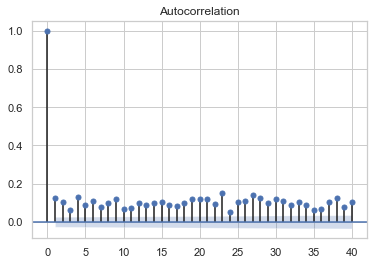

In [25]:
arima.plot_acf()

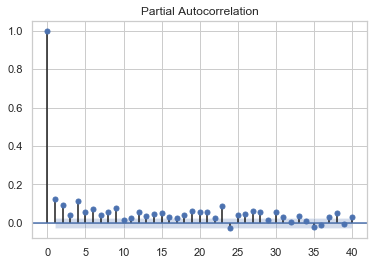

In [26]:
arima.plot_pacf()

#### Using ARIMA with dynamic regression, which is an auto_ARIMA
auto_arima() uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

Fit ARIMA: order=(1, 0, 1); AIC=-5603.789, BIC=-5577.132, Fit time=1.556 seconds
Fit ARIMA: order=(0, 0, 0); AIC=-5061.635, BIC=-5048.306, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0); AIC=-5150.436, BIC=-5130.443, Fit time=0.054 seconds
Fit ARIMA: order=(0, 0, 1); AIC=-5136.060, BIC=-5116.067, Fit time=0.040 seconds
Fit ARIMA: order=(2, 0, 1); AIC=-5603.850, BIC=-5570.528, Fit time=2.122 seconds
Fit ARIMA: order=(2, 0, 0); AIC=-5196.631, BIC=-5169.974, Fit time=0.060 seconds
Fit ARIMA: order=(2, 0, 2); AIC=-5602.593, BIC=-5562.606, Fit time=2.305 seconds
Fit ARIMA: order=(3, 0, 2); AIC=-5609.431, BIC=-5562.780, Fit time=3.368 seconds
Fit ARIMA: order=(4, 0, 2); AIC=-5619.807, BIC=-5566.492, Fit time=4.291 seconds
Fit ARIMA: order=(4, 0, 1); AIC=-5614.223, BIC=-5567.573, Fit time=2.687 seconds
Fit ARIMA: order=(4, 0, 3); AIC=-5617.928, BIC=-5557.948, Fit time=5.625 seconds
Fit ARIMA: order=(3, 0, 1); AIC=-5601.894, BIC=-5561.907, Fit time=2.446 seconds
Fit ARIMA: order=(5, 0, 3); 

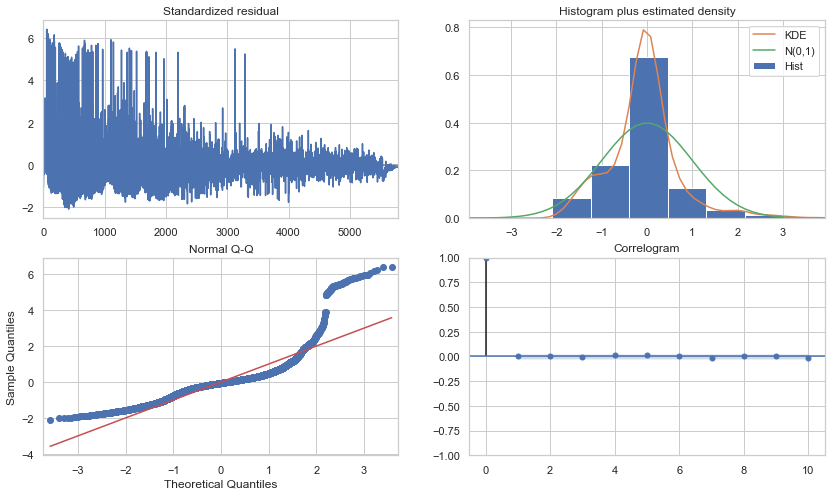

In [27]:
arima.auto_ARIMA()

**Plot interpretation:**

**Top left:** The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right:** The density plot suggest normal distribution with mean zero.

**Bottom left:** All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right:** The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. 

Overall, it seems to be a good fit. Let’s forecast.

**Step4: Forcast**

Forecast Accuracy of Price using ARIMA(5,1,5): 
 MAE = 0.1043
RMSE = 0.1658


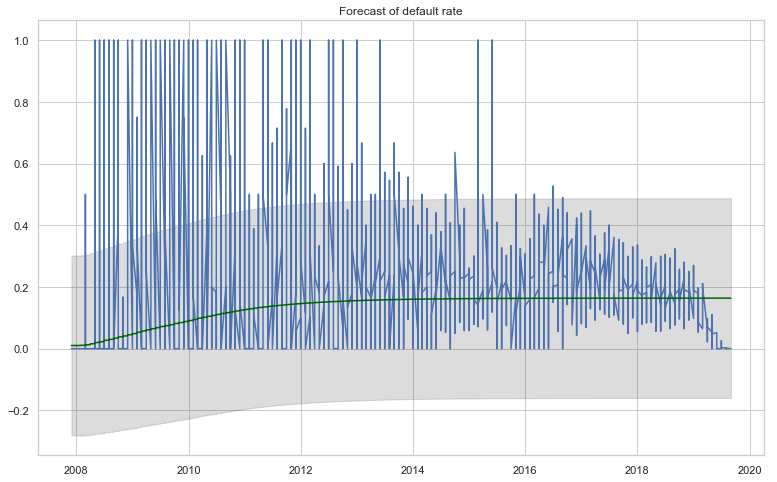

In [28]:
arima.forecast()

**Conclusion**: From the time series analysis, the default rate seems predictable. With the better management and operation of lending club, their default rate declines significantly recent years.

### PART2

In [29]:
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy as shc
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
import datetime

In [31]:
data=pd.read_csv('data.csv',index_col=0)

In [32]:
data['year']=list(map(lambda x:int(str(x)[:4]),data['time']))
data['month']=list(map(lambda x:int(str(x)[5:7]),data['time']))

In [33]:
new=data[['state','year','defaults','total_loans']].groupby(['state','year']).agg(['sum'])
new['default_rate']=new['defaults']/new['total_loans']

In [34]:
new.head()

defaults total_loans default_rate
                sum         sum             
state year                                  
AK    2009      2.0           2     1.000000
      2010      1.0           3     0.333333
      2011      3.0          11     0.272727
      2012      3.0          25     0.120000
      2013     14.0          74     0.189189

In [35]:
states=np.unique(data['state'])
state_yearly=pd.DataFrame()
for i in states:
    state_yearly[i]=new.xs(i)['default_rate']

In [36]:
states

array(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [37]:
state_yearly=state_yearly.dropna(1)
state_yearly.columns

Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IL', 'KS', 'KY', 'LA', 'MA', 'MD', 'MI', 'MN', 'MO', 'MT', 'NC', 'NH',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WY'],
      dtype='object')

In [38]:
state_yearly

,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,...,RI,SC,TN,TX,UT,VA,VT,WA,WI,WY
year,,,,,,,,,,,,,,,,,,,,,
2009,1.000000,0.200000,0.333333,0.517241,0.553957,0.285714,0.187500,0.666667,0.500000,0.662338,...,0.500000,0.363636,0.400000,0.391304,0.600000,0.343750,0.500000,0.409091,0.166667,0.000000
2010,0.333333,0.258065,0.214286,0.296296,0.371053,0.283582,0.243902,0.153846,0.333333,0.316832,...,0.307692,0.285714,0.375000,0.290323,0.347826,0.171429,0.666667,0.307692,0.244444,0.000000
2011,0.272727,0.127273,0.230769,0.173554,0.221670,0.220472,0.135922,0.111111,0.066667,0.293194,...,0.066667,0.254237,0.000000,0.172070,0.250000,0.138655,0.000000,0.210084,0.191176,0.000000
2012,0.120000,0.222222,0.161290,0.241135,0.252482,0.167401,0.222222,0.063492,0.166667,0.255196,...,0.222222,0.205882,0.000000,0.200243,0.225806,0.179426,0.266667,0.246809,0.251799,0.043478
2013,0.189189,0.258065,0.270270,0.205970,0.224037,0.207407,0.211538,0.169492,0.223881,0.281187,...,0.269231,0.234483,0.451220,0.215566,0.194313,0.206332,0.230769,0.262673,0.250000,0.222222
2014,0.181287,0.265839,0.247727,0.214824,0.208633,0.176056,0.214511,0.116279,0.218935,0.252648,...,0.244186,0.213205,0.323398,0.197197,0.198319,0.224558,0.211864,0.212240,0.198966,0.153846
2015,0.181818,0.253382,0.234101,0.218202,0.193893,0.163993,0.187657,0.118812,0.226131,0.228823,...,0.201587,0.179285,0.283688,0.199052,0.203795,0.232004,0.181070,0.176247,0.210950,0.189944
2016,0.263081,0.305016,0.315155,0.244225,0.233280,0.186870,0.233294,0.169492,0.239695,0.262701,...,0.243487,0.208393,0.265933,0.254987,0.203667,0.249063,0.157175,0.192006,0.208830,0.214789
2017,0.217064,0.258225,0.257002,0.209824,0.219651,0.173833,0.187272,0.146482,0.217565,0.225772,...,0.187215,0.173337,0.221032,0.222619,0.176259,0.218971,0.145429,0.157668,0.169085,0.203060


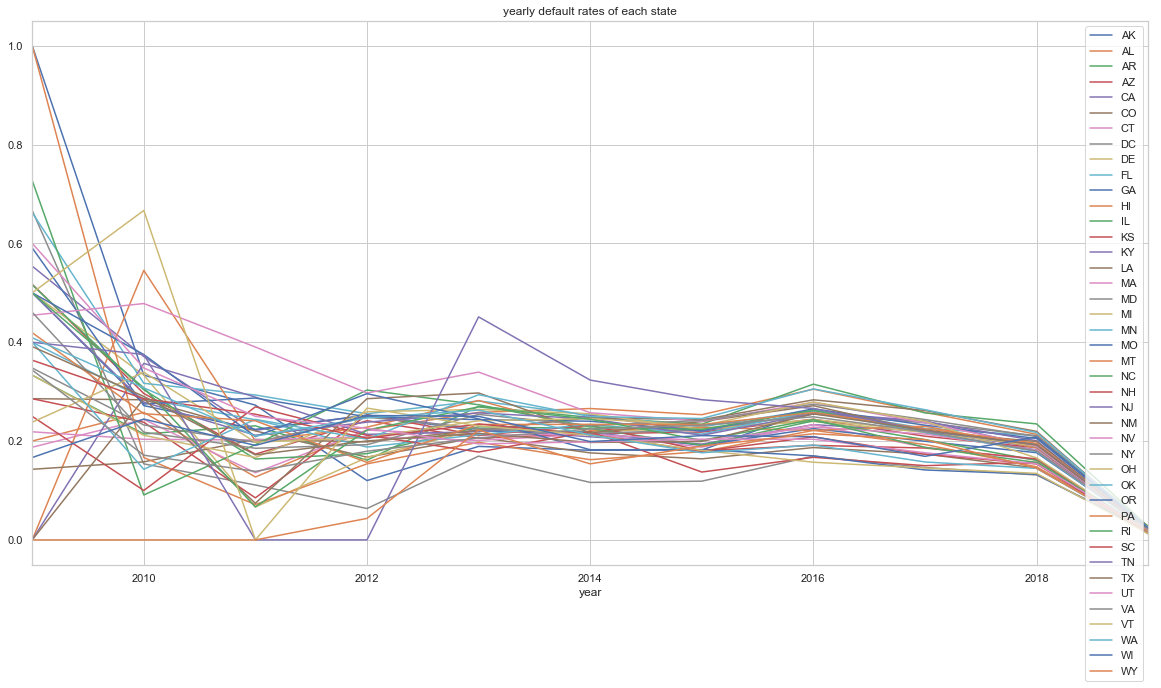

In [39]:
state_yearly.plot(figsize=(20,10),title='yearly default rates of each state')

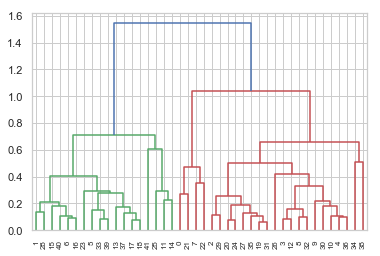

In [40]:
dend = shc.dendrogram(shc.linkage(state_yearly.T, method='ward'))  
plt.show()

Based on the tree structure above, any choice of 2 or 3 clusters seems reasonable. 

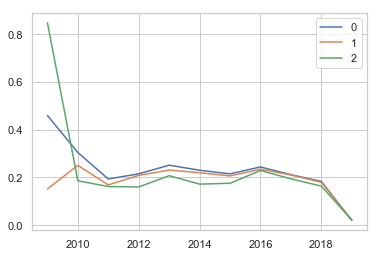

In [41]:
kmeans = KMeans(n_clusters=3).fit(state_yearly.T)
centroids = kmeans.cluster_centers_
plt.plot(state_yearly.index,centroids[0],label=0)
plt.plot(state_yearly.index,centroids[1],label=1)
plt.plot(state_yearly.index,centroids[2],label=2)
plt.legend()
plt.show()

In [42]:
kmeans.fit_predict(state_yearly.T)

array([2, 0, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 2,
       2, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0],
      dtype=int32)

In [43]:
x=state_yearly.T

In [44]:
x['center']=kmeans.fit_predict(state_yearly.T)

In [45]:
x[x['center']==0].index

Index(['AL', 'CO', 'CT', 'HI', 'KS', 'KY', 'LA', 'MA', 'NH', 'NM', 'OH', 'WI',
       'WY'],
      dtype='object')

In [46]:
x[x['center']==1].index
# most of them are conservative states
# people make loan decisions more carefully

Index(['AR', 'AZ', 'CA', 'DE', 'FL', 'GA', 'IL', 'MD', 'MI', 'MN', 'MO', 'NJ',
       'NV', 'NY', 'OK', 'OR', 'PA', 'RI', 'SC', 'TN', 'TX', 'UT', 'VA', 'VT',
       'WA'],
      dtype='object')

In [47]:
x[x['center']==2].index

Index(['AK', 'DC', 'MT', 'NC'], dtype='object')

In [48]:
# pick 2019 and see the clusters of monthly default rates
temp1=data[data['year']==2019]
temp1=temp1[temp1['month']<=8]
temp2=data[data['year']==2018]
temp2=temp2[temp2['month']>8]

In [49]:
temp=pd.concat([temp2,temp1])

In [50]:
state_monthly=pd.DataFrame()
for i in states:
    try:
        state_monthly[i]=np.array(temp[temp['state']==i]['default_rate'])
    except:
        pass
state_monthly.index=np.unique(temp['time'])

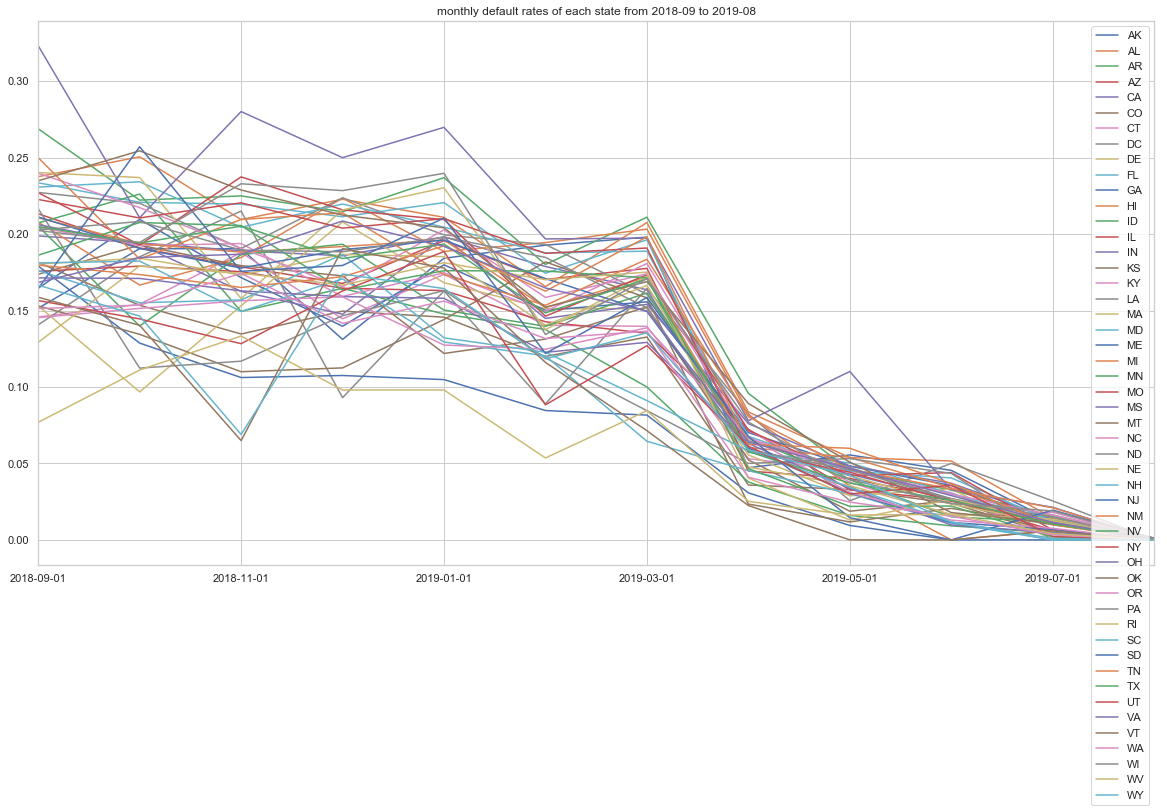

In [51]:
state_monthly.plot(figsize=(20,10),title='monthly default rates of each state from 2018-09 to 2019-08')

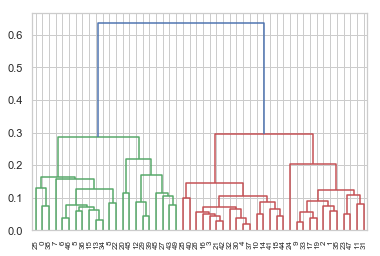

In [52]:
dend = shc.dendrogram(shc.linkage(state_monthly.T, method='ward'))  
plt.show()

Based on the tree structure above, any choice of 2 or 4 clusters seems reasonable. 

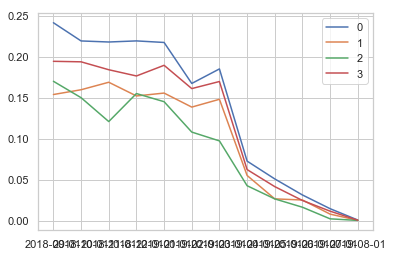

In [53]:
kmeans = KMeans(n_clusters=4).fit(state_monthly.T)
centroids = kmeans.cluster_centers_
plt.plot(state_monthly.index,centroids[0],label=0)
plt.plot(state_monthly.index,centroids[1],label=1)
plt.plot(state_monthly.index,centroids[2],label=2)
plt.plot(state_monthly.index,centroids[3],label=3)
plt.legend()
plt.show()

In [54]:
x=state_monthly.T
x['center']=kmeans.fit_predict(state_monthly.T)

In [55]:
x[x['center']==0].index

Index(['AL', 'AR', 'FL', 'LA', 'MD', 'MO', 'MS', 'NE', 'NM', 'NY', 'OK', 'WI'], dtype='object')

In [56]:
x[x['center']==1].index
# highest

Index(['ME', 'MT', 'ND', 'VT', 'WV', 'WY'], dtype='object')

In [57]:
x[x['center']==2].index

Index(['AK', 'AZ', 'CA', 'GA', 'HI', 'IN', 'KY', 'MA', 'MI', 'NC', 'NJ', 'NV',
       'PA', 'RI', 'SD', 'TN', 'TX', 'VA'],
      dtype='object')

In [58]:
x[x['center']==3].index
# lowest

Index(['CO', 'CT', 'DC', 'DE', 'ID', 'IL', 'KS', 'MN', 'NH', 'OH', 'OR', 'SC',
       'UT', 'WA'],
      dtype='object')

The relation between low default rates and highly conservative states still exists.  
Compared with the list of the richest states in America for 2018(https://www.homesnacks.net/richest-states-in-america-1211659/), there seems to be no clear relationship between the richness of states and their default rates. 

### PART3 

In [59]:
default_data = pd.read_csv('default_rate_by_month_state_count.csv', index_col=0)
default_data.date = pd.to_datetime(default_data.date)

#unemp_data = pd.read_csv('monthly_unemployment_rate_toJan2019.csv')

loan_data['last_pymnt_d'] = pd.to_datetime(loan_data['last_pymnt_d'])

num_of_loans_each_state = loan_data[['id','addr_state']].groupby('addr_state').agg(['count'])['id']

In [60]:
'''function plots pie chart for attribute'''

def pieplot(attr_name, data=loan_data, plot=True):
    
    if plot == True:
        compo = data[['id',attr_name]].groupby(attr_name).count()
    
        #special cases
        if attr_name == 'grade':
            compo.drop(index='G',inplace=True)
        if attr_name == 'home_ownership':
            compo.drop(index=['ANY','NONE','OTHER'],inplace=True)
        if attr_name == 'loan_status':
            compo = compo.loc[['Charged Off','Current','Fully Paid']]

        # Pie chart
        labels = list(compo.index)
        sizes = list(compo.id)
    
        #explsion
        explode = tuple([0.05]*len(sizes))

        plt.pie(
            sizes, 
            labels=labels, 
            autopct='%1.0f%%', 
            startangle=90, 
            pctdistance=0.8, 
            labeldistance=0, 
            shadow=True, 
            radius=1,
            explode=explode,
            textprops=dict(weight='bold', style='italic', size=15, color='w')
        )
    
        #draw circle
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)
        fig.set_figheight(5)
        fig.set_figwidth(6)
        fig.legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize='xx-large')

        # Equal aspect ratio ensures that pie is drawn as a circle
        plt.axis('equal')  
        plt.tight_layout()
        plt.title('Composition of '+attr_name)
        plt.show();
    

In [61]:
'''function returns default percentage re. attribute'''

def attr_default_pct(attr_name, data=loan_data, plot=True, returnRes=False):
    
    attr_df = data[['id','loan_status',attr_name]].groupby([attr_name,'loan_status']).count()
    attr_list = list(data[['id',attr_name]].groupby(attr_name).count().index)
    
    if attr_name == 'home_ownership':
        attr_list.remove('ANY')
        attr_list.remove('NONE')
        attr_list.remove('OTHER')
            
        
    default_pct = []
    
    for i, gr in enumerate(attr_list):
        if 'Default' not in data.loan_status:
            rate = attr_df.loc[gr].loc['Charged Off'].values[0] / attr_df.loc[gr].values.sum()
        else:
            rate = (attr_df.loc[gr].loc['Charged Off'] + attr_df.loc[gr].loc['Default']).values[0] / attr_df.loc[gr].values.sum()
        default_pct.append(rate)
    
    res = pd.DataFrame(default_pct, index=attr_list, columns=['default_pct'])
    
    hfont = {'fontname':'Helvetica','size':18}

    if plot == True:
        plt.figure(figsize=(20,10))
        plt.bar(res.index,res['default_pct'], width=0.5)
        plt.xlabel(attr_name,**hfont)
        plt.ylabel("Default Percentage",**hfont)
        plt.title("Default Percentage vs " + attr_name, **hfont)
        plt.show()
    
    if returnRes == True:
        return res

#### 3.1 general analysis

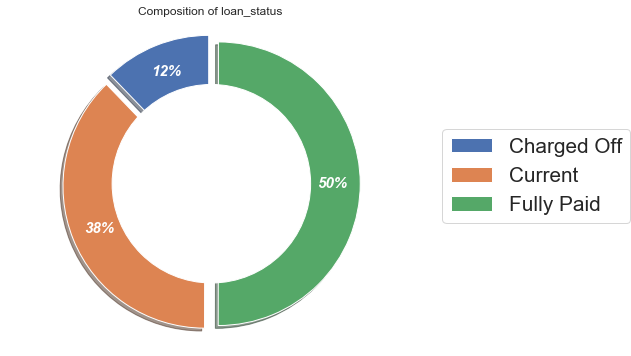

In [62]:
pieplot('loan_status')

general 12% of default rate in total loans

#### grade

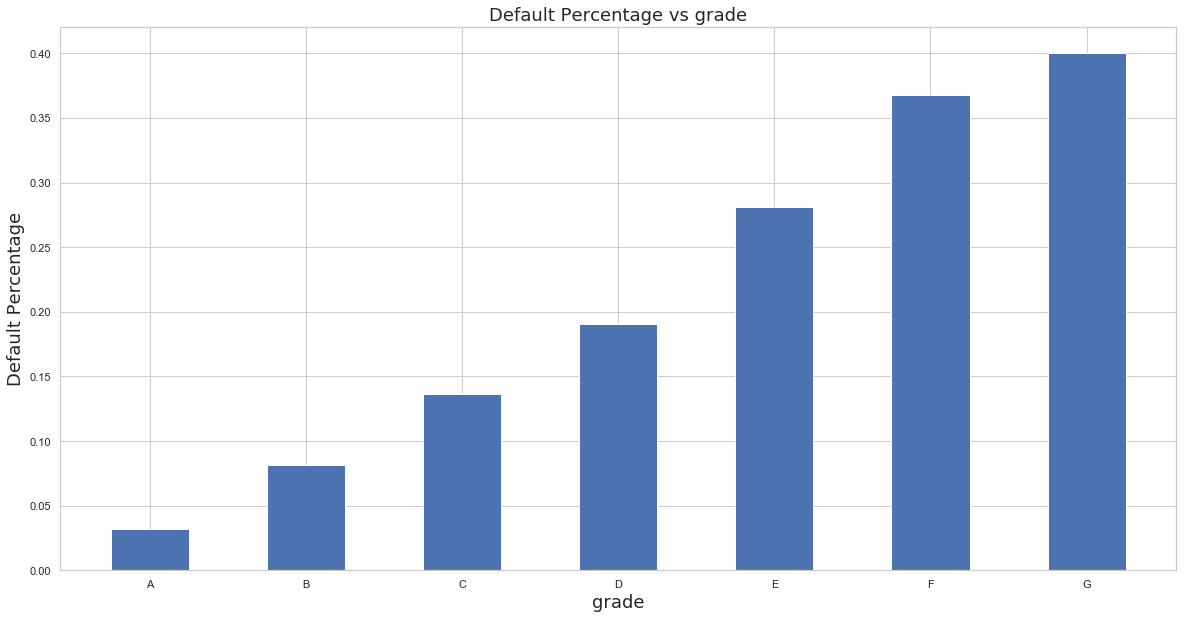

In [63]:
attr_default_pct('grade')

significant negative linear relationship between the grade and default percentage!

higher grades mean lower default

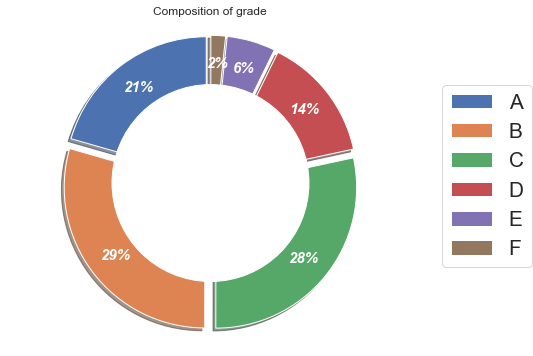

In [64]:
pieplot('grade')

large weighting in A B C grades

#### term

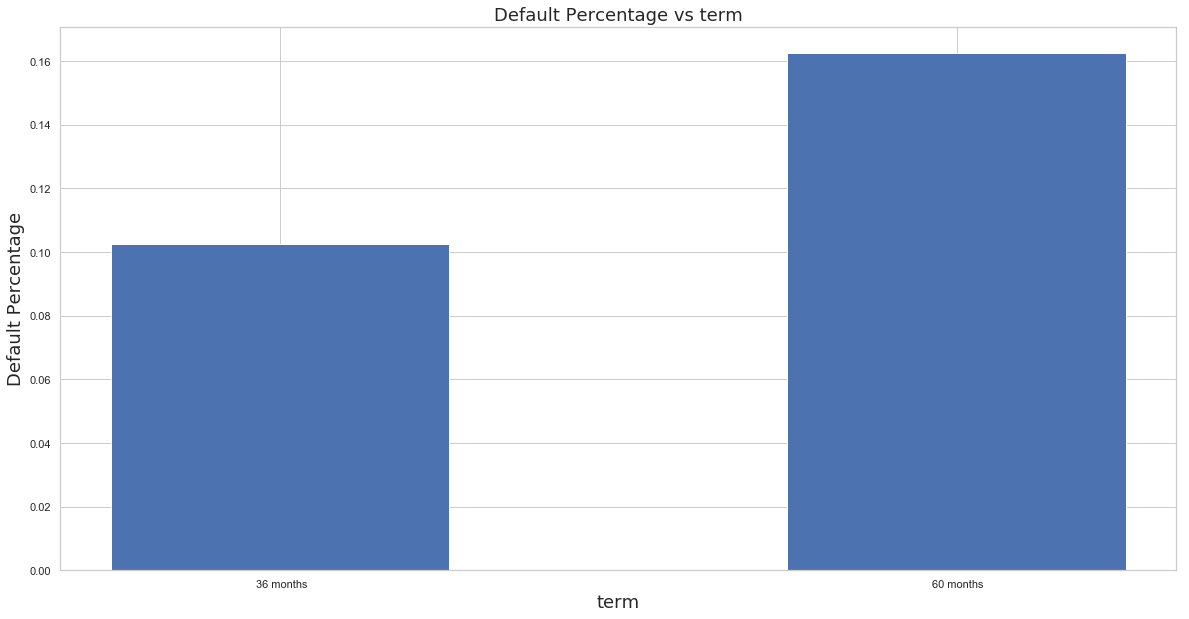

In [65]:
attr_default_pct('term')

longer term loans more likely to default

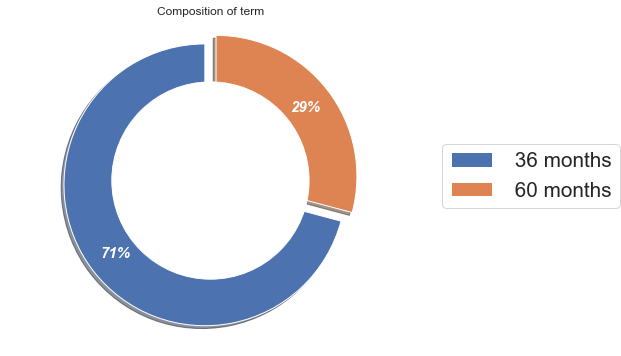

In [66]:
pieplot('term')

#### employment length

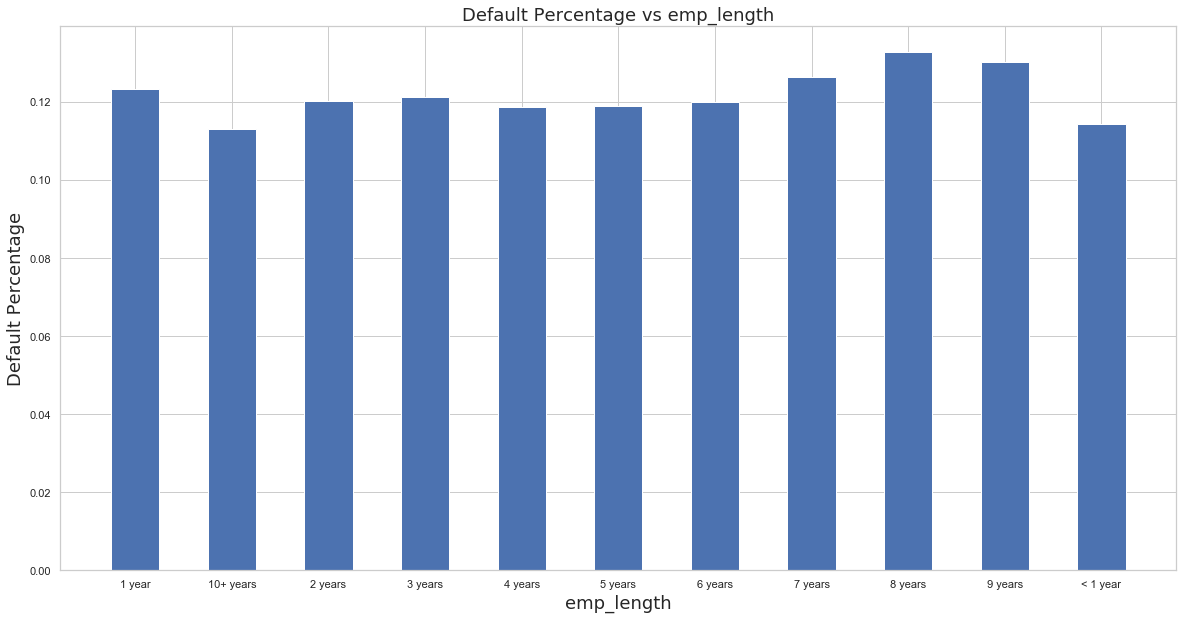

In [67]:
attr_default_pct('emp_length')

default percentages same for all employment lengths

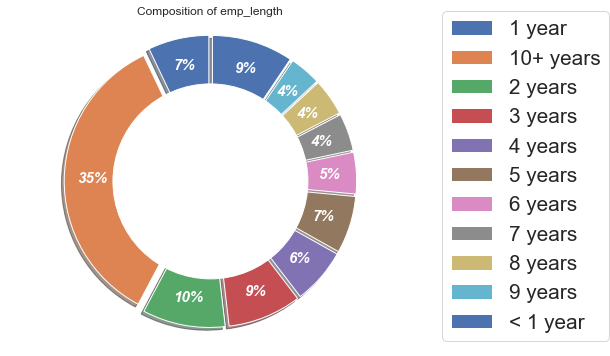

In [68]:
pieplot('emp_length')

lending club issues the most loans to borrowers who has been working for 10+ yrs

#### home ownership

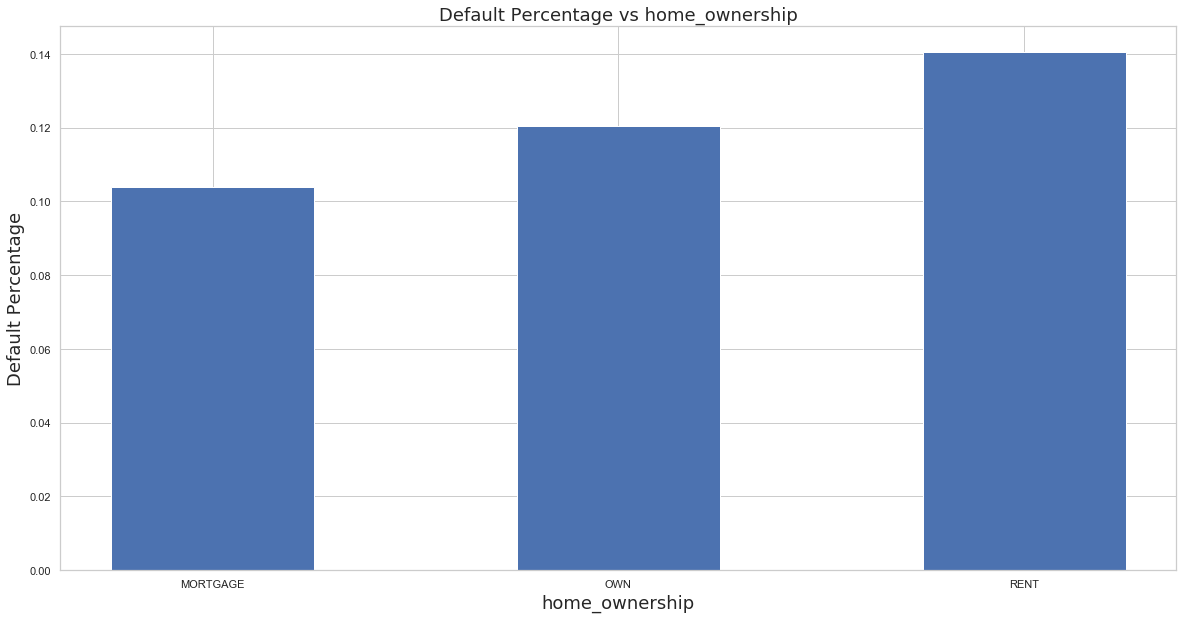

In [69]:
attr_default_pct('home_ownership')

higher default percentage for borrowers who rent home

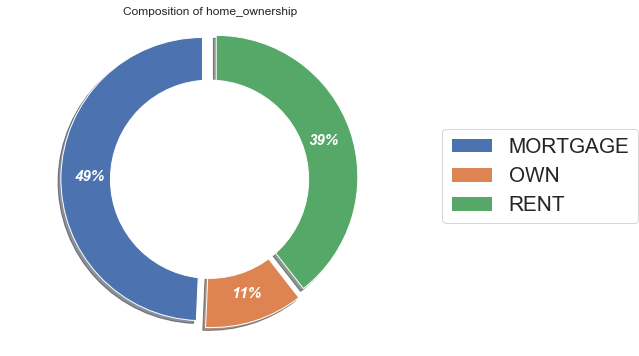

In [70]:
pieplot('home_ownership')

borrowers with owned home are less likely to turn to lending club for loans

### 2. more factors

# underfunded

In [71]:
underfunded = loan_data[loan_data.loan_amnt!=loan_data.funded_amnt]

underfunded loans, defined as those loans that did not get full amount as requested

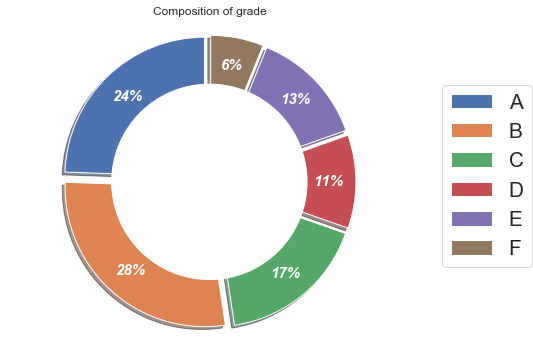

In [72]:
pieplot('grade',underfunded)

Surprisingly, a large part of the underfunded loans are A and B grades

In underfunded loans:


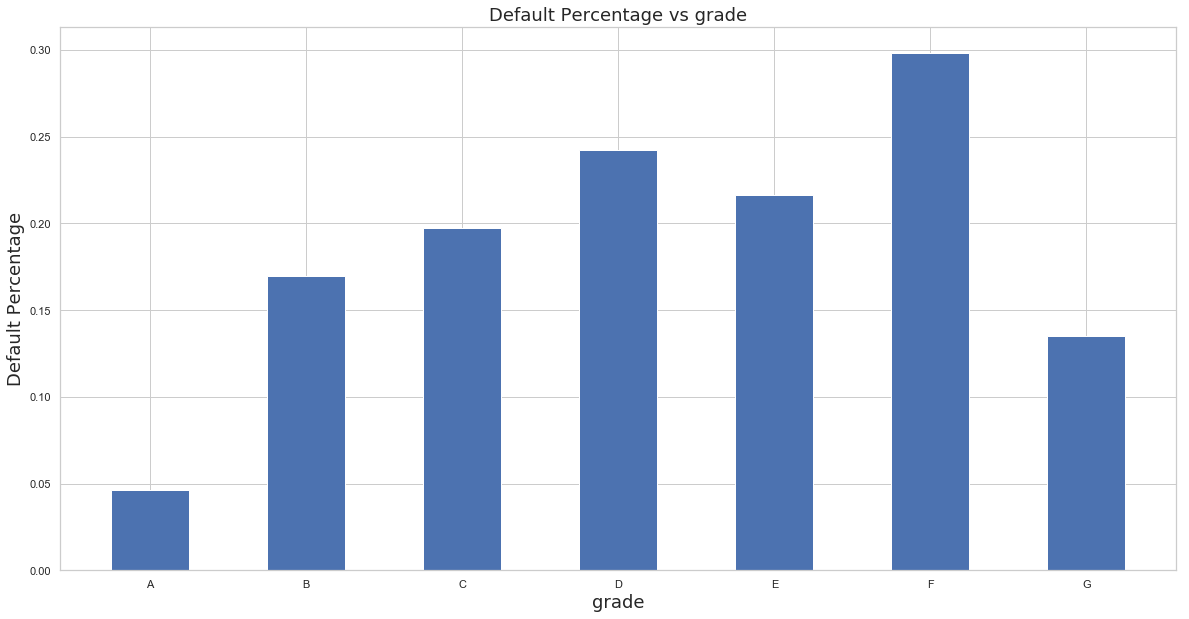

In [73]:
print('In underfunded loans:')
attr_default_pct('grade',underfunded)

For those underfunded loans that defaulted, the grades of loans are less dominating

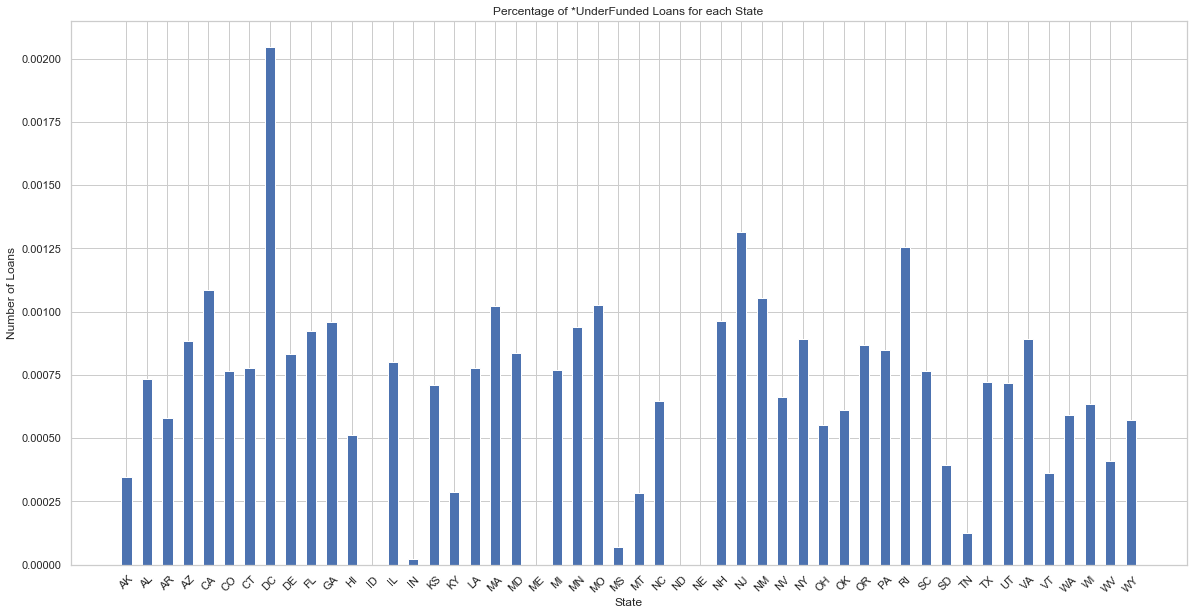

In [74]:
underfunded_state = underfunded[['id','addr_state']].groupby(['addr_state']).count()

under_state_pct = underfunded_state.id / num_of_loans_each_state.loc[:,'count']
under_state_pct.drop(index='IA', inplace=True) # drop outlier Iowa

plt.figure(figsize=(20,10))
plt.bar(under_state_pct.index, under_state_pct.values, width=0.5)
plt.xlabel("State")
plt.ylabel("Number of Loans")
plt.title("Percentage of *UnderFunded Loans for each State")
plt.xticks(rotation=45)
plt.show();

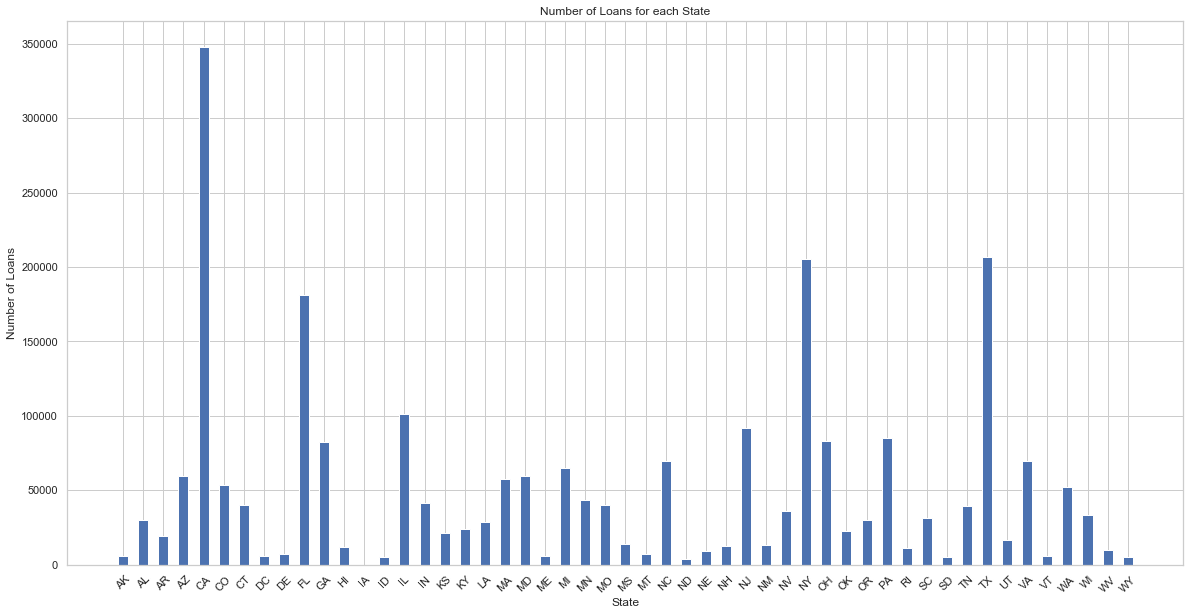

In [75]:
plt.figure(figsize=(20,10))
plt.bar(num_of_loans_each_state.index,num_of_loans_each_state.loc[:,'count'],width=0.5)
plt.xlabel("State")
plt.ylabel("Number of Loans")
plt.title("Number of Loans for each State")
plt.xticks(rotation=45)
plt.show();

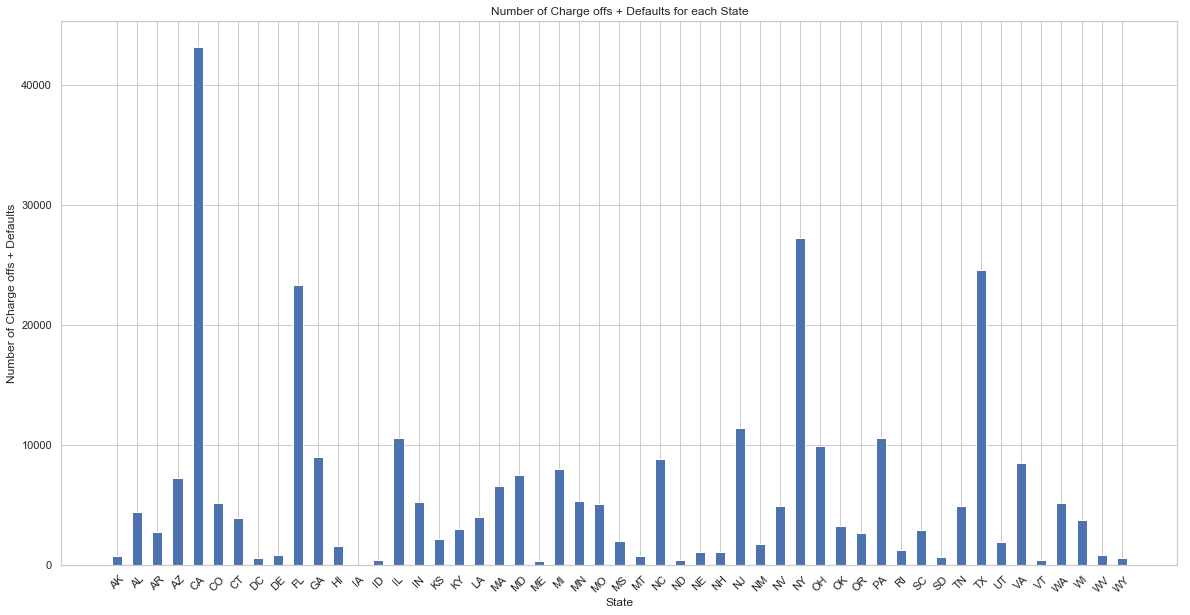

In [76]:
a = loan_data[['id','addr_state','loan_status']].groupby(['loan_status','addr_state']).agg(['count'])
chg_off = a.loc['Charged Off',:]['id']
defaulted = a.loc['Default',:]['id']
final_default = []
for index,row in chg_off.iterrows():
    if index in defaulted.index:
        final_default.append(row[0]+defaulted.loc[index,'count'])
    else:
        final_default.append(row[0])
#final_default = pd.DataFrame(zip(*[final_default,list(chg_off.index)]),columns=['count','state'])
final_default = pd.DataFrame({'count':final_default,'state':list(chg_off.index)})

plt.figure(figsize=(20,10))
plt.bar(final_default['state'],final_default['count'],width=0.5)
plt.xlabel("State")
plt.ylabel("Number of Charge offs + Defaults")
plt.title("Number of Charge offs + Defaults for each State")
plt.xticks(rotation=45)
plt.show();

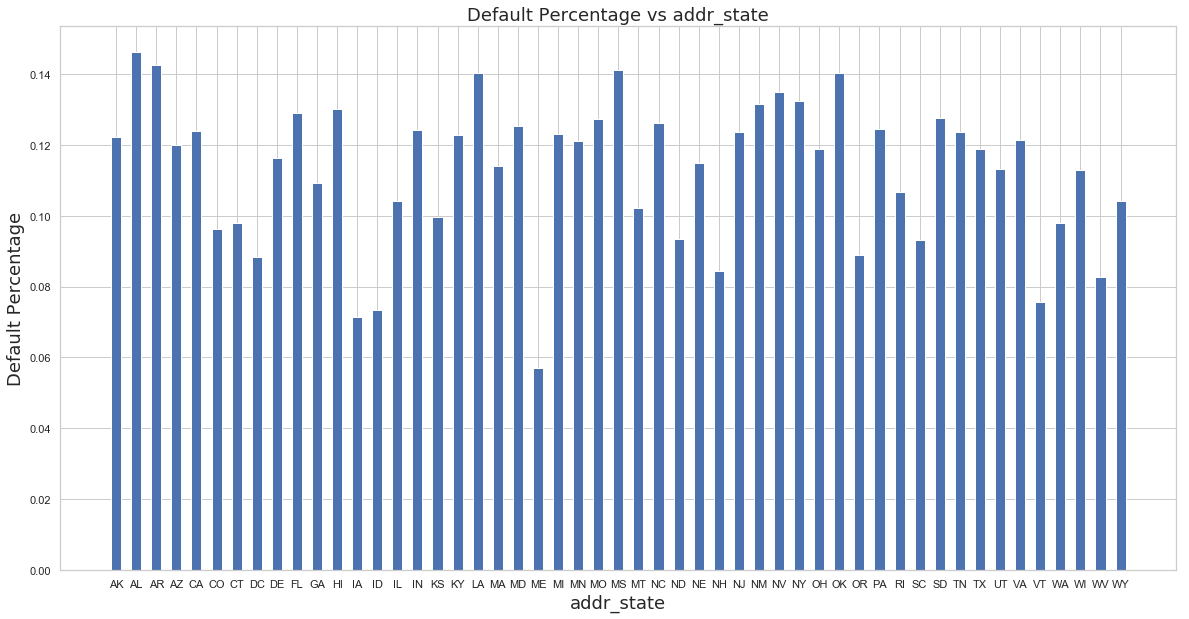

In [77]:
attr_default_pct('addr_state')

positive relation ship between the number of loans and percentage of underfunded loans

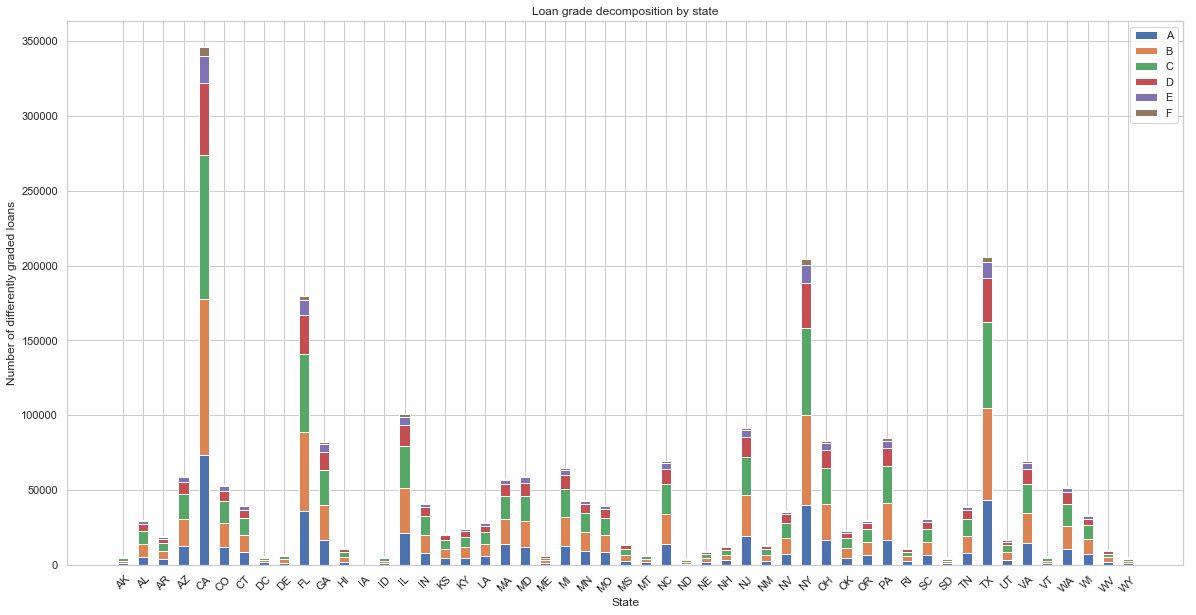

In [119]:
state_grade = loan_data[['id','addr_state','grade']].groupby(['grade','addr_state']).count()

stateA = state_grade.loc['A'].id
stateB = state_grade.loc['B'].id
stateC = state_grade.loc['C'].id
stateD = state_grade.loc['D'].id
stateE = state_grade.loc['E'].id
stateF = state_grade.loc['F'].id
stateG = state_grade.loc['G'].id

ind = num_of_loans_each_state.index    # the x locations for the groups
width = 0.5      # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, stateA, width)
p2 = plt.bar(ind, stateB, width,
             bottom=stateA)
p3 = plt.bar(ind, stateC, width,
             bottom=stateA+stateB)
p4 = plt.bar(ind, stateD, width,
             bottom=stateA+stateB+stateC)
p5 = plt.bar(ind, stateE, width,
             bottom=stateA+stateB+stateC+stateD)
p6 = plt.bar(ind, stateF, width,
             bottom=stateA+stateB+stateC+stateD+stateE)


plt.ylabel('Number of differently graded loans')
plt.xlabel('State')
plt.title('Loan grade decomposition by state')
plt.xticks(ind, rotation=45)

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('A','B','C','D','E','F'))

plt.show()

Loan grade decomposition by state

In [79]:
num_of_loans_each_state_top10 = num_of_loans_each_state.sort_values('count',ascending=False)[:10]
num_of_loans_each_state_top10 # top 10 states with the most number of loans

,count
addr_state,
CA,347772
TX,206662
NY,205247
FL,180828
IL,100957
NJ,91974
PA,84778
OH,83292
GA,82397


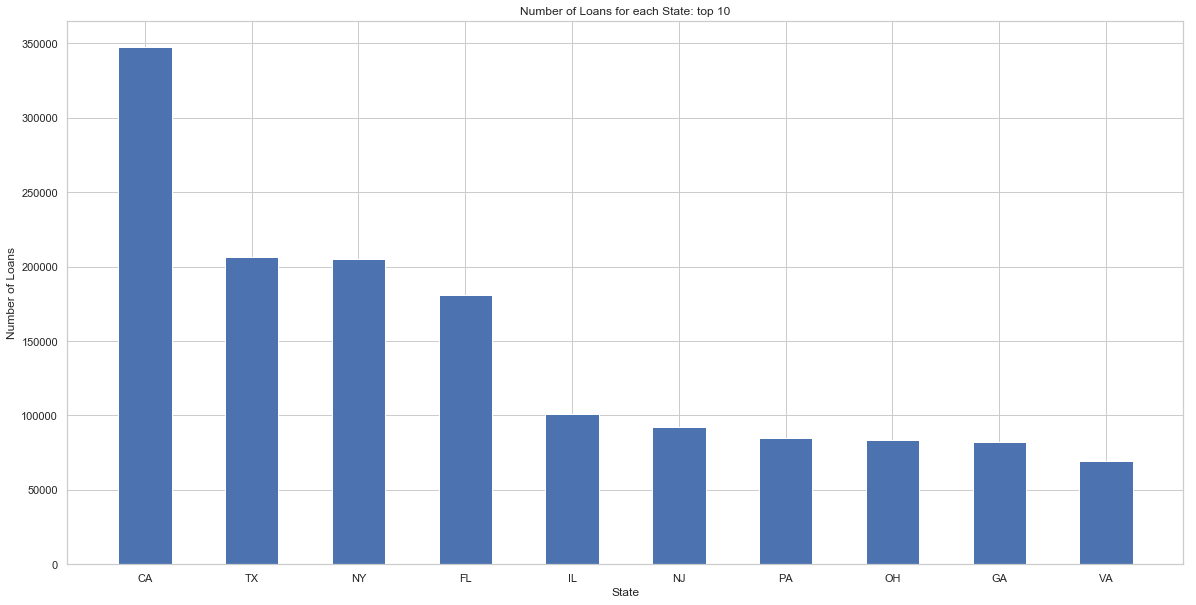

In [80]:
plt.figure(figsize=(20,10))
plt.bar(num_of_loans_each_state_top10.index,num_of_loans_each_state_top10.loc[:,'count'],width=0.5)
plt.xlabel("State")
plt.ylabel("Number of Loans")
plt.title("Number of Loans for each State: top 10")
plt.show();

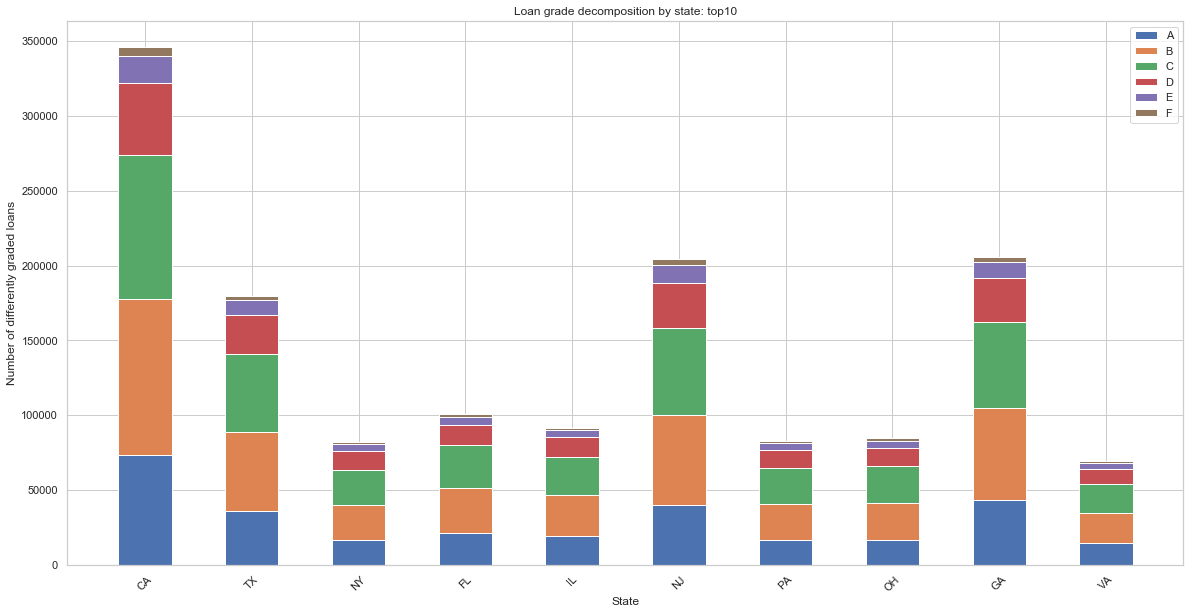

In [81]:
# CAUTION: used same variable names

loan_data_top10 = loan_data[loan_data.addr_state.isin(num_of_loans_each_state_top10.index)]

state_grade = loan_data_top10[['id','addr_state','grade']].groupby(['grade','addr_state']).count()

stateA = state_grade.loc['A'].id
stateB = state_grade.loc['B'].id
stateC = state_grade.loc['C'].id
stateD = state_grade.loc['D'].id
stateE = state_grade.loc['E'].id
stateF = state_grade.loc['F'].id
stateG = state_grade.loc['G'].id

ind = num_of_loans_each_state_top10.index    # the x locations for the groups
width = 0.5      # the width of the bars: can also be len(x) sequence

plt.figure(figsize=(20,10))
p1 = plt.bar(ind, stateA, width)
p2 = plt.bar(ind, stateB, width,
             bottom=stateA)
p3 = plt.bar(ind, stateC, width,
             bottom=stateA+stateB)
p4 = plt.bar(ind, stateD, width,
             bottom=stateA+stateB+stateC)
p5 = plt.bar(ind, stateE, width,
             bottom=stateA+stateB+stateC+stateD)
p6 = plt.bar(ind, stateF, width,
             bottom=stateA+stateB+stateC+stateD+stateE)


plt.ylabel('Number of differently graded loans')
plt.xlabel('State')
plt.title('Loan grade decomposition by state: top10')
plt.xticks(ind, rotation=45)

plt.legend((p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]), ('A','B','C','D','E','F'))

plt.show()

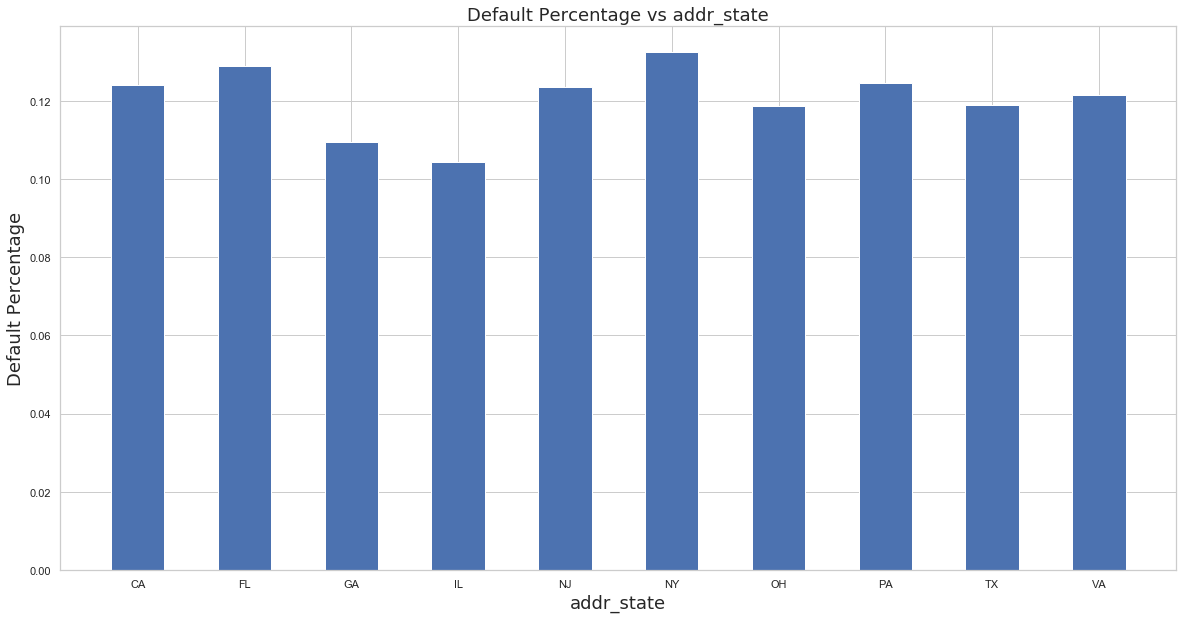

In [82]:
attr_default_pct('addr_state', data=loan_data_top10)

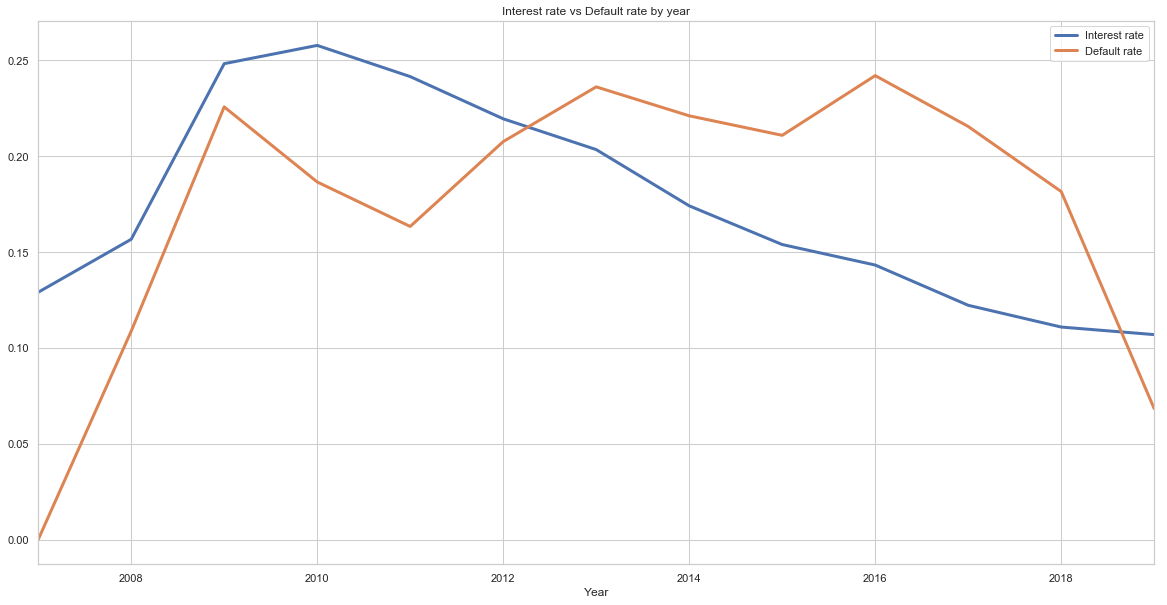

In [120]:
unemp_default_df = unemp_data[['Year','Month','State','Rate']].groupby('Year').mean().iloc[17:]
unemp_default_df['Default rate'] = default_data[['date','states','default rate']].groupby('date').mean().groupby(pd.Grouper(freq="Y")).mean()['default rate'].values
unemp_default_df.rename(columns={'Rate':'Interest rate'},inplace=True)
normalizer = np.mean(unemp_default_df['Default rate'])/np.mean(unemp_default_df['Interest rate'])
unemp_default_df['Interest rate'] *= normalizer

unemp_default_df.plot(figsize=(20,10),title='Interest rate vs Default rate by year',linewidth=3)

## PART4

In [121]:
num_of_loans_each_state = loan_data[['id','addr_state']].groupby('addr_state').agg(['count'])['id']

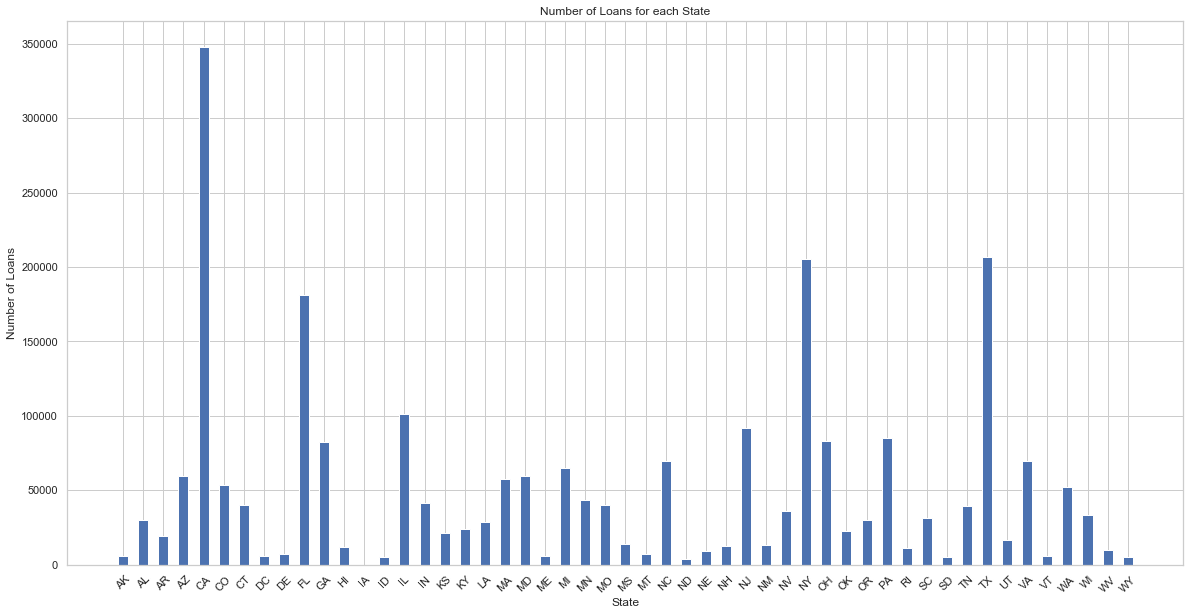

In [122]:
plt.figure(figsize=(20,10))
plt.bar(num_of_loans_each_state.index,num_of_loans_each_state.loc[:,'count'],width=0.5)
plt.xlabel("State")
plt.ylabel("Number of Loans")
plt.title("Number of Loans for each State")
plt.xticks(rotation=45)
plt.show()

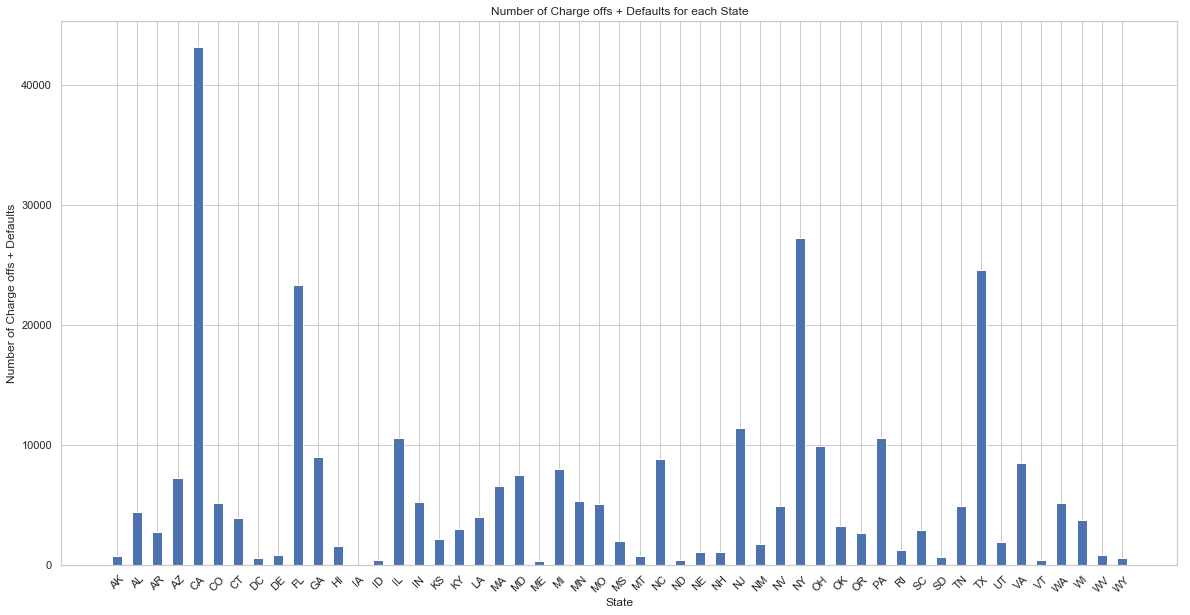

In [123]:
a = loan_data[['id','addr_state','loan_status']].groupby(['loan_status','addr_state']).agg(['count'])
chg_off = a.loc['Charged Off',:]['id']
defaulted = a.loc['Default',:]['id']
final_default = []
for index,row in chg_off.iterrows():
    if index in defaulted.index:
        final_default.append(row[0]+defaulted.loc[index,'count'])
    else:
        final_default.append(row[0])
final_default = pd.DataFrame(list(zip(*[final_default,list(chg_off.index)])),columns=['count','state'])
plt.figure(figsize=(20,10))
plt.bar(final_default['state'],final_default['count'],width=0.5)
plt.xlabel("State")
plt.ylabel("Number of Charge offs + Defaults")
plt.title("Number of Charge offs + Defaults for each State")
plt.xticks(rotation=45)
plt.show()

In [124]:
def calculate_default_rate(loan_data,num_of_loans_each_state,term='Full'):
    if term=='Full':
        df = loan_data
        title = 'complete dataset'
    elif term == '60':
        df = loan_data[loan_data['term']==' 60 months']
        title = '60 months term loans'
    elif term == '36':
        df = loan_data[loan_data['term']==' 36 months']
        title = '36 months term loans'
    total_loans_each_state = df[['id','addr_state']].groupby('addr_state').agg(['count'])['id']
    a = df[['id','addr_state','loan_status']].groupby(['loan_status','addr_state']).agg(['count'])
    chg_off = a.loc['Charged Off',:]['id']
    defaulted = a.loc['Default',:]['id']
    final_default = []
    #set_trace()
    for index,row in chg_off.iterrows():
        if index in defaulted.index:
            final_default.append(row[0]+defaulted.loc[index,'count'])
        else:
            final_default.append(row[0])
    final_default = pd.DataFrame(list(zip(*[final_default,list(chg_off.index)])),columns=['count','state'])
    final_default_rate = np.array(final_default['count'])/np.array(total_loans_each_state['count'])
    final_default_rate = pd.DataFrame(list(zip(*[final_default_rate, list(final_default['state'])])),columns=['default rate','state'])
    plt.figure(figsize=(20,10))
    plt.bar(final_default_rate['state'],final_default_rate['default rate'],width=0.5)
    plt.xlabel("State")
    plt.ylabel("Default Rate")
    plt.title("Default Rate vs State for " + title)
    plt.xticks(rotation=45)
    plt.show()
    return final_default_rate

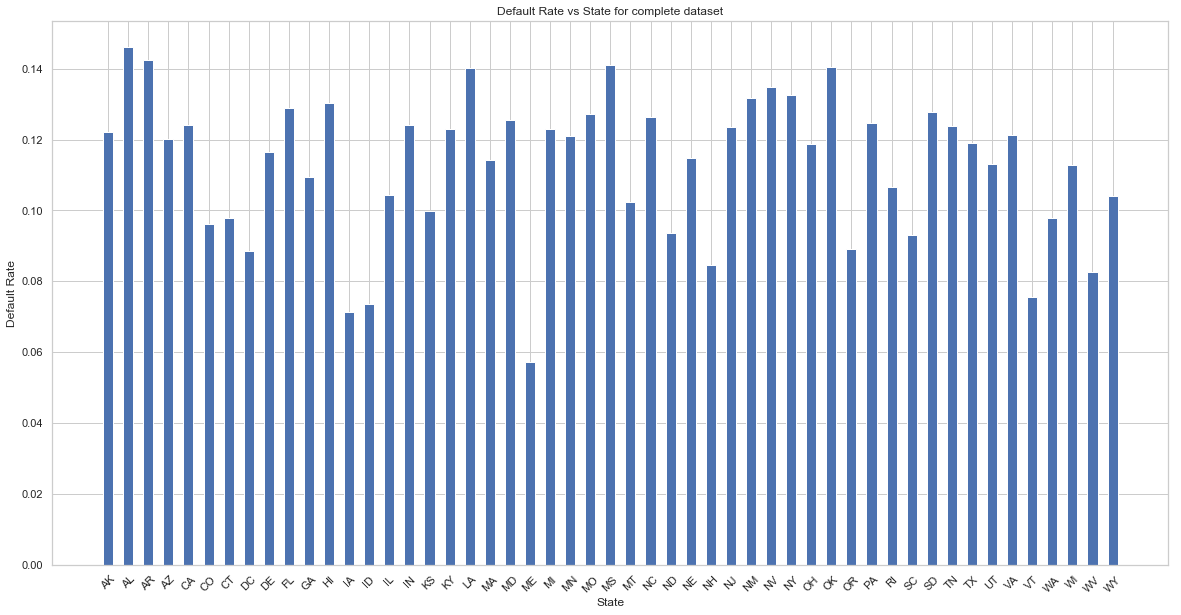

In [125]:
def_rate_full = calculate_default_rate(loan_data,num_of_loans_each_state,term='Full')

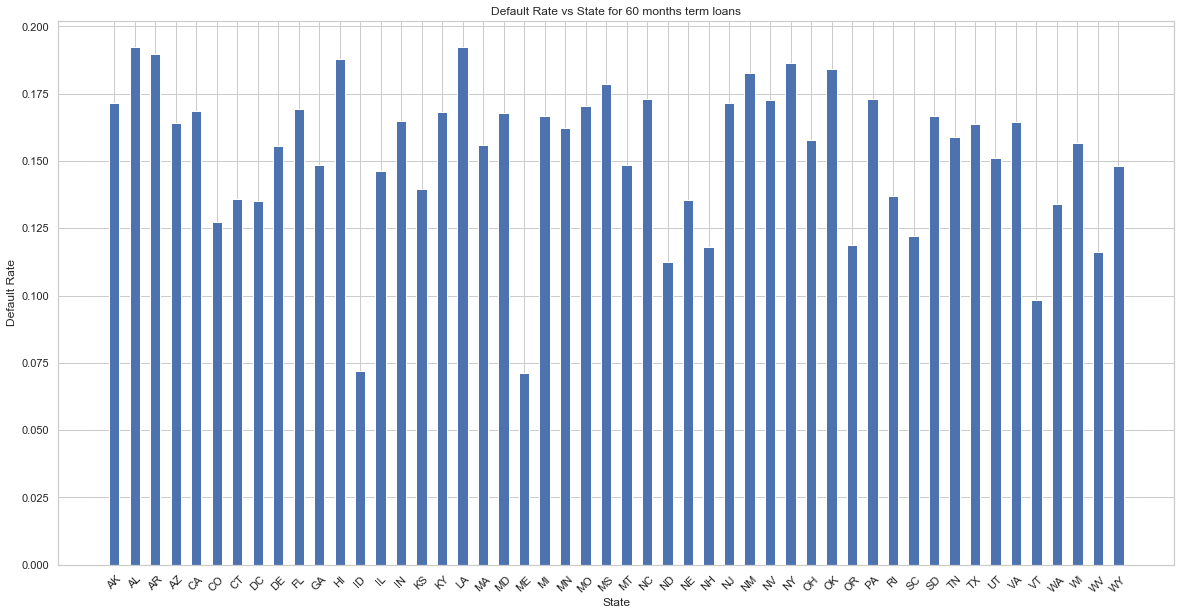

In [126]:
def_rate_60_months = calculate_default_rate(loan_data,num_of_loans_each_state,term='60')

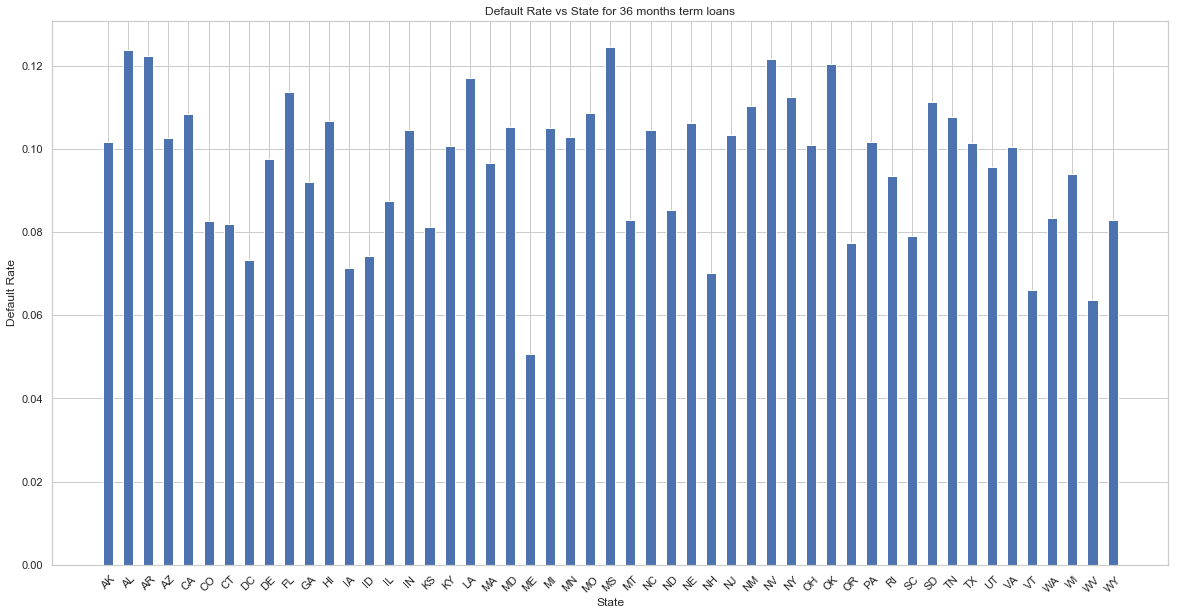

In [127]:
def_rate_36_months = calculate_default_rate(loan_data,num_of_loans_each_state,term='36')

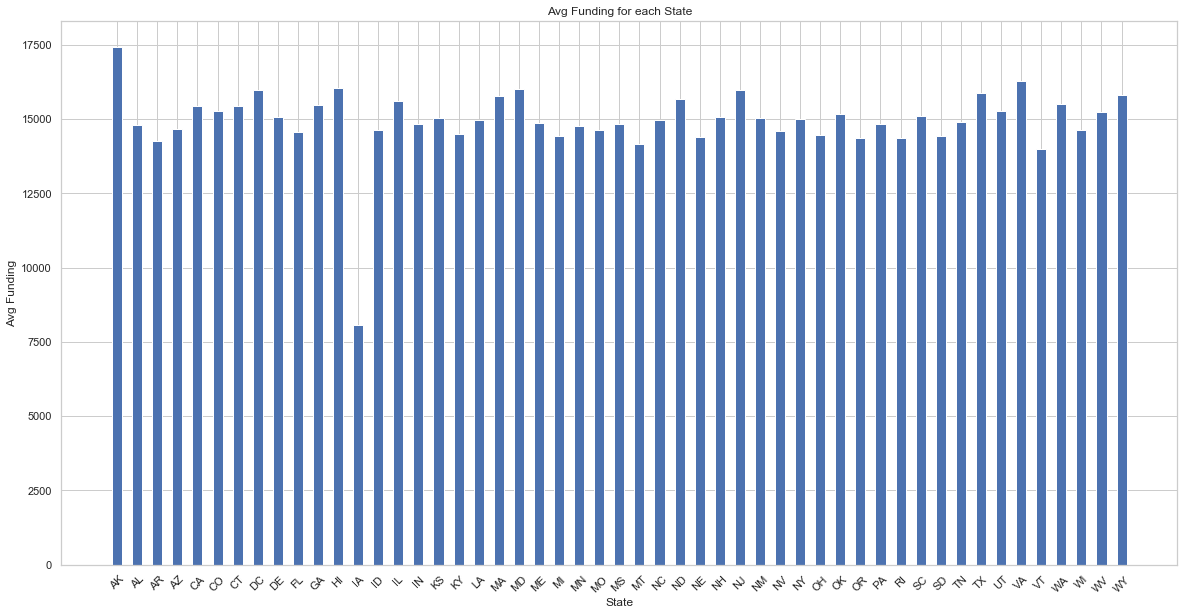

In [85]:
avg_funding = loan_data[['funded_amnt','addr_state']].groupby('addr_state').agg(['mean'])['funded_amnt']
plt.figure(figsize=(20,10))
plt.bar(avg_funding.index,avg_funding.loc[:,'mean'],width=0.5)
plt.xlabel("State")
plt.ylabel("Avg Funding")
plt.title("Avg Funding for each State")
plt.xticks(rotation=45)
plt.show()

In [86]:
avg_funding

,mean
addr_state,
AK,17429.473411
AL,14803.610685
AR,14251.507577
AZ,14681.657400
CA,15450.096974
CO,15260.358847
CT,15448.489108
DC,15988.346121
DE,15077.496533


Creating a dataframe of states, month-year and default rate

In [87]:
def calculate_monthly_default_rates(loan_data):
    months_years = pd.to_datetime(loan_data['last_pymnt_d'].unique()).sort_values()
    months_years = months_years[months_years.notnull()]
    final_df = []
    for i in range(0,months_years.shape[0]):
        d1 = months_years[i]
        try:
            d2 = months_years[i+1]
            df = loan_data[(loan_data['last_pymnt_d']>=d1) & (loan_data['last_pymnt_d']<d2)]
        except:
            df = loan_data[(loan_data['last_pymnt_d']>=d1)]
        total_loans_each_state = df[['id','addr_state']].groupby('addr_state').agg(['count'])['id']
        status_df = df[['id','addr_state','loan_status']].groupby(['loan_status','addr_state']).agg(['count'])
        try:
            chg_off = status_df.loc['Charged Off',:]['id']
            for idx,row in total_loans_each_state.iterrows():
                if idx not in chg_off.index:
                    chg_off.loc[idx,'count'] = 0
        except:
            chg_off = pd.DataFrame(zip(*[[0]*total_loans_each_state.shape[0],list(total_loans_each_state.index)]),columns=['count','addr_state'])
            chg_off.set_index('addr_state',inplace=True,drop=True)
        try:
            chg_off_credit_policy = status_df.loc['Does not meet the credit policy. Status:Charged Off',:]['id']
            for idx,row in total_loans_each_state.iterrows():
                if idx not in chg_off_credit_policy.index:
                    chg_off_credit_policy.loc[idx,'count'] = 0
        except:
            chg_off_credit_policy = pd.DataFrame(zip(*[[0]*total_loans_each_state.shape[0],list(total_loans_each_state.index)]),columns=['count','addr_state'])    
            chg_off_credit_policy.set_index('addr_state',inplace=True,drop=True)
        try:
            defaulted = status_df.loc['Default',:]['id']
            for idx,row in total_loans_each_state.iterrows():
                if idx not in defaulted.index:
                    defaulted.loc[idx,'count'] = 0
        except:
            defaulted = pd.DataFrame(list(zip(*[[0]*total_loans_each_state.shape[0],list(total_loans_each_state.index)])),columns=['count','addr_state'])
            defaulted.set_index('addr_state',inplace=True,drop=True)
        final_default = []
        for index,row1 in chg_off.iterrows():
            final_default.append(row1[0]+defaulted.loc[index,'count'] + chg_off_credit_policy.loc[index,'count'])
        final_default = pd.DataFrame(list(zip(*[final_default,list(chg_off.index)])),columns=['count','state'])
        final_default.sort_values('state',inplace=True)
        total_loans_each_state.sort_index(inplace=True)
        final_default_rate = np.array(final_default['count'])/np.array(total_loans_each_state['count'])
        final_df.extend(np.c_[list(final_default['state']),[d1]*final_default['state'].shape[0],list(final_default_rate),list(final_default['count']),list(total_loans_each_state['count'])])
    return pd.DataFrame(final_df,columns=['state','time','default_rate','defaults','total_loans'])

In [88]:
final_df = calculate_monthly_default_rates(loan_data)
#to calculate default rates for a particular grade of loans, just pass the filtered dataframe to the above function

Loading monthly unemployment rates for each state

In [91]:
unemp_data = pd.read_csv("monthly_unemployment_rate_toJan2019.csv")

Total loan default stats from Lending club website and from our data

Principal outstanding for each state

In [128]:
principal_outstanding_df = loan_data[loan_data['loan_status']=='Current'][['id','addr_state','funded_amnt','total_rec_prncp']]
principal_outstanding_df['princ_outstanding'] = principal_outstanding_df['funded_amnt']-principal_outstanding_df['total_rec_prncp']
exp_by_state = principal_outstanding_df.groupby('addr_state').agg(['sum'])
exp_by_state['princ_outstanding']

,sum
addr_state,
AK,2.537015e+07
AL,1.131637e+08
AR,7.422163e+07
AZ,2.305568e+08
CA,1.347475e+09
CO,2.107225e+08
CT,1.756175e+08
DC,2.178413e+07
DE,3.013520e+07


# Regressions

removed IA since no total loans greater than 10

In [94]:
def run_regression(final_df):
    states = final_df['state'].unique()
    regression_results = []
    failed =[]
    for st in states:
        if st in ['IA']:
            continue
        df1 = final_df[final_df['state']==st]
        df1 = df1[df1['total_loans']>10]
        df1['unemp_rate'] = [0]*df1.shape[0]
        for i in range(0,df1.shape[0]):
            try:
                df1.iloc[i,-1] = 0.01*unemp_data[(unemp_data['Year']==df1.iloc[i,1].year) &(unemp_data['Month_num']==df1.iloc[i,1].month)&(unemp_data['State']==df1.iloc[i,0])].iloc[0,-1]
            except: 
                df1.iloc[i,-1] = df1.iloc[i-1,-1]
        X = df1['unemp_rate']
        Y = df1['default_rate']
        X = sm.add_constant(X)
        res = sm.OLS(Y,X).fit(cov_type='HAC',cov_kwds={'maxlags':4})# using newey west erros since there seems to be some correlation in errors
        regression_results.append([st,res.params[1],res.tvalues[1],res.rsquared_adj])
    result = pd.DataFrame(regression_results,columns=['State','Coeff.','tvalue','Adj. Rsquared'])
    result_sig = result[abs(result['tvalue'])>2]
    plt.figure(figsize=(20,10))
    plt.bar(result_sig['State'],result_sig['Coeff.'], width=0.5)
    plt.show()
    return result


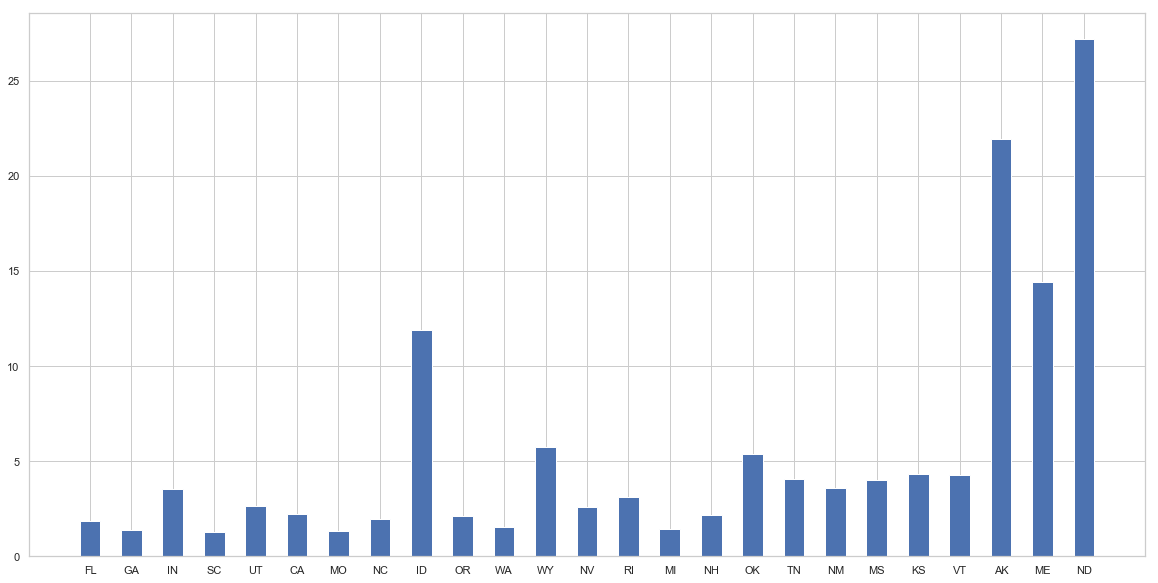

In [96]:
reg_results = run_regression(final_df)

In [99]:
reg_results

,State,Coeff.,tvalue,Adj. Rsquared
0,FL,1.836239,2.769542,0.235759
1,NY,-0.227807,-0.343959,-0.004714
2,GA,1.370324,3.343157,0.197445
3,IN,3.533059,2.764961,0.241347
4,MA,0.210208,0.396109,-0.005104
5,MD,0.598032,0.780863,0.004614
6,NJ,0.764862,1.412286,0.054317
7,OH,0.246546,0.318344,-0.005998
8,SC,1.265194,2.268073,0.164115
9,AR,0.625571,0.709990,0.002562


In [106]:
states_with_significant_stat = reg_results[abs(reg_results['tvalue'])>=2.0]

In [107]:
states_with_significant_stat.sort_values('tvalue',inplace=True)
states_with_significant_stat

,State,Coeff.,tvalue,Adj. Rsquared
38,NH,2.173830,2.014687,0.077397
15,MO,1.351004,2.159468,0.096380
25,WY,5.726758,2.167455,0.110254
8,SC,1.265194,2.268073,0.164115
23,WA,1.540023,2.417565,0.178426
44,KS,4.315301,2.429360,0.083671
45,VT,4.247904,2.519485,0.117566
48,ME,14.418762,2.738614,0.209608
3,IN,3.533059,2.764961,0.241347
0,FL,1.836239,2.769542,0.235759


In [108]:
unemp_vol = unemp_data[['State','Rate']].groupby('State').agg(['std'])['Rate']
unemp_vol

,std
State,
AK,0.465009
AL,2.315977
AR,1.605523
AZ,2.556969
CA,2.965245
CO,1.636569
CT,1.744440
DC,1.636414
DE,1.554063


Calculating possible loss of principal if unemployments rates suddenly increase by 1 std deviation

In [109]:
unemp_shock=[]
for i in range(0,states_with_significant_stat.shape[0]):
    shock = 0.01*states_with_significant_stat.iloc[i,1]*unemp_vol.loc[states_with_significant_stat.iloc[i,0],'std']*exp_by_state.loc[states_with_significant_stat.iloc[i,0],'princ_outstanding'][0]
    percent = 100*shock/exp_by_state.loc[states_with_significant_stat.iloc[i,0],'princ_outstanding'][0]
    unemp_shock.append([states_with_significant_stat.iloc[i,0],shock,percent])
unemp_shock = pd.DataFrame(unemp_shock,columns=['State','Loss','%Loss'])
total_loss = unemp_shock['Loss'].sum()
print('Total loss on portfolio if unemployment rates inc by 1 std deviation is = ' + str(unemp_shock['Loss'].sum()))
print('State wise losses are shown below')
unemp_shock['Loss'] = unemp_shock['Loss'].map('{:,.2f}'.format)
print('%loss on portfolio = ' +str(100*total_loss/exp_by_state['princ_outstanding'].sum()[0])+'%')
unemp_shock


Total loss on portfolio if unemployment rates inc by 1 std deviation is = 266137997.5694517
State wise losses are shown below
%loss on portfolio = 2.6285216479860583%


,State,Loss,%Loss
0,NH,"1,631,150.89",3.145584
1,MO,"3,830,987.20",2.446741
2,WY,"1,266,245.11",5.917144
3,SC,"4,335,798.07",3.164636
4,WA,"6,353,542.02",3.018946
5,KS,"2,965,795.51",3.392459
6,VT,"1,419,353.24",6.229088
7,ME,"9,051,845.10",26.696274
8,IN,"12,770,310.13",7.448795
9,FL,"35,756,286.35",4.978033


Calculating possible loss of principal if unemployments rates increase by 1%

In [110]:
unemp_sens=[]
for i in range(0,states_with_significant_stat.shape[0]):
    shock = 0.01*states_with_significant_stat.iloc[i,1]*1*exp_by_state.loc[states_with_significant_stat.iloc[i,0],'princ_outstanding'][0]
    percent = 100*shock/exp_by_state.loc[states_with_significant_stat.iloc[i,0],'princ_outstanding'][0]
    unemp_sens.append([states_with_significant_stat.iloc[i,0],shock,percent])
unemp_sens = pd.DataFrame(unemp_sens,columns=['State','Loss','%Loss'])
total_loss = unemp_sens['Loss'].sum()
print('Total loss on portfolio if unemployment rates inc by 1% for all states is = ' + str(unemp_sens['Loss'].sum()))
print('State wise losses are shown below')
unemp_sens['Loss'] = unemp_sens['Loss'].map('{:,.2f}'.format)
print('%loss on portfolio = ' +str(100*total_loss/exp_by_state['princ_outstanding'].sum()[0])+'%')
unemp_sens


Total loss on portfolio if unemployment rates inc by 1% for all states is = 122428571.85657948
State wise losses are shown below
%loss on portfolio = 1.2091702590234485%


,State,Loss,%Loss
0,NH,"1,127,245.62",2.173830
1,MO,"2,115,336.21",1.351004
2,WY,"1,225,503.29",5.726758
3,SC,"1,733,414.65",1.265194
4,WA,"3,241,065.11",1.540023
5,KS,"3,772,573.73",4.315301
6,VT,"967,922.84",4.247904
7,ME,"4,888,936.88",14.418762
8,IN,"6,057,121.37",3.533059
9,FL,"13,189,359.94",1.836239


In [111]:
exp_by_state['princ_outstanding'].sum()[0]

10125006875.0

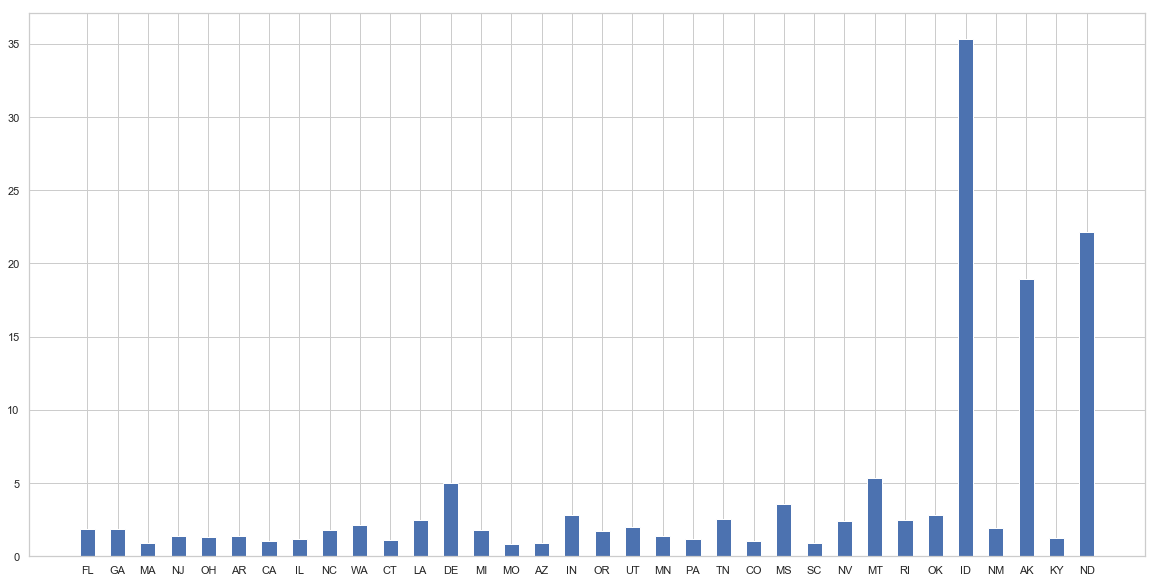

In [112]:
final_df_gradeAB = calculate_monthly_default_rates(loan_data[loan_data['grade'].isin(['A','B'])])
reg_results_gradeAB = run_regression(final_df_gradeAB)

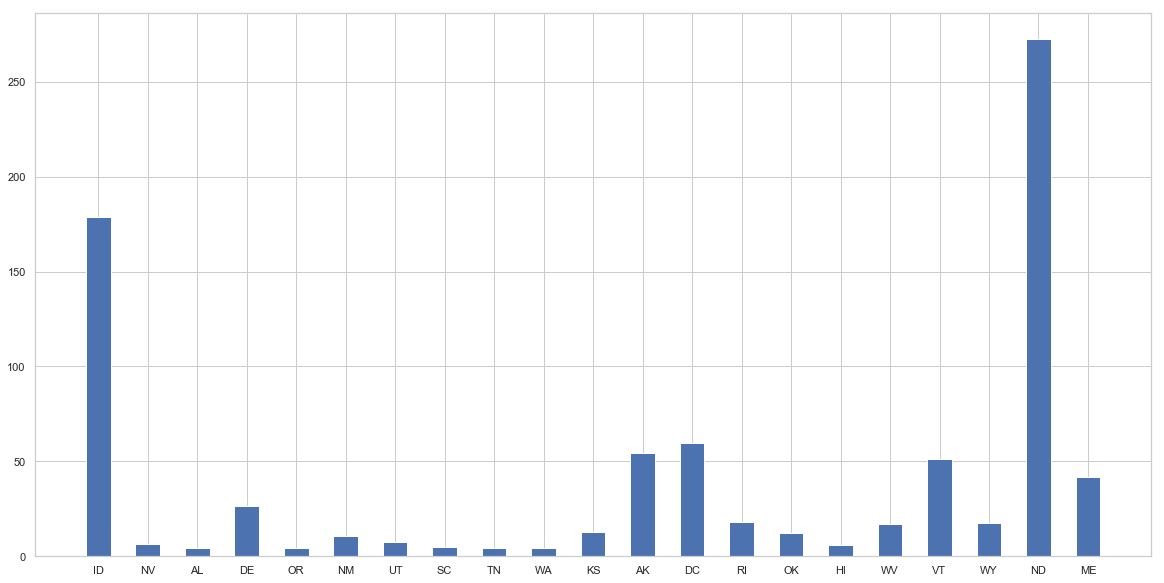

In [113]:
final_df_gradeEFG = calculate_monthly_default_rates(loan_data[loan_data['grade'].isin(['E','F','G'])])
reg_results_gradeEFG = run_regression(final_df_gradeEFG)

In [114]:
reg_results_gradeAB[abs(reg_results_gradeAB['tvalue'])>2.0]

,State,Coeff.,tvalue,Adj. Rsquared
0,FL,1.846790,5.370318,0.363160
2,GA,1.897148,5.570773,0.357173
3,MA,0.929510,2.434311,0.085523
5,NJ,1.364838,3.113891,0.227888
6,OH,1.350351,2.425685,0.113271
7,AR,1.417088,2.113150,0.070091
8,CA,1.047680,3.696210,0.262930
9,IL,1.181636,3.049200,0.164384
10,NC,1.769116,4.621532,0.334604
11,WA,2.105168,3.908667,0.347194


In [115]:
print('Number of states where unemployment explains default rates significantly for grade AB loans is = ' + str(reg_results_gradeAB[abs(reg_results_gradeAB['tvalue'])>2.0].shape[0]))

Number of states where unemployment explains default rates significantly for grade AB loans is = 34


In [116]:
print('Number of states where unemployment explains default rates significantly for grade EFG loans is = ' + str(reg_results_gradeEFG[abs(reg_results_gradeEFG['tvalue'])>2.0].shape[0]))


Number of states where unemployment explains default rates significantly for grade EFG loans is = 21


In [117]:
print('Number of states where unemployment explains default rates significantly for all grade loans is = ' + str(reg_results[abs(reg_results['tvalue'])>=2.0].shape[0]))


Number of states where unemployment explains default rates significantly for all grade loans is = 25
